# 🏴‍☠️ AN2DL25 Challenge 1 — Pirate Pain Classification

This notebook implements a full deep-learning pipeline for multivariate time-series classification of the Pirate Pain dataset. It is inspired by the Lecture 4 notebook (`Timeseries Classification (1).ipynb`) but adapted for the competition setting, including data preparation, model training (RNN/GRU/LSTM variants), evaluation, and test-time inference.



In [300]:
import os
import random
import math
import copy
from pathlib import Path
from typing import Tuple, Dict, Optional, List, Any, Sequence
from datetime import datetime
from itertools import product
import inspect

import numpy as np
import pandas as pd
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

try:
    from torch.amp import autocast, GradScaler
except ImportError:  # pragma: no cover
    from torch.cuda.amp import autocast, GradScaler



In [301]:
SEED = 9

try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:  # pragma: no cover
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive', force_remount=False)
    BASE_DIR = Path('/content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge')
else:
    BASE_DIR = Path('/Users/md101ta/Desktop/Pirates')

DATA_DIR = (BASE_DIR / 'data').resolve()
DATA_DIR_CANDIDATES = [
    Path('/content/drive/MyDrive/[2025-2026] AN2DL/Challenge'),
    Path('/content/drive/MyDrive/[2025-2026]\\ A2NDL/Challenge'),
    BASE_DIR / 'data'
]

for candidate in DATA_DIR_CANDIDATES:
    if candidate.exists():
        DATA_DIR = candidate
        break
else:
    raise FileNotFoundError('Nessuna DATA_DIR valida trovata')

print(f'Usando DATA_DIR: {DATA_DIR}')
OUTPUT_DIR = (BASE_DIR / 'outputs').resolve()
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    DEVICE = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    DEVICE = torch.device('cpu')

print(f'Running in Colab: {IN_COLAB}')
print(f'Device: {DEVICE}')
print(f'Data dir: {DATA_DIR}')
print(f'Output dir: {OUTPUT_DIR}')

_AUTocast_params = inspect.signature(autocast).parameters
_GRADSCALER_PARAMS = inspect.signature(GradScaler).parameters

def autocast_context():
    enabled = DEVICE.type == 'cuda'
    if 'device_type' in _AUTocast_params:
        return autocast(device_type=DEVICE.type, enabled=enabled)
    if 'device' in _AUTocast_params:
        return autocast(DEVICE.type, enabled=enabled)
    # fallback to legacy signature (enabled only)
    return autocast(enabled=enabled)


def create_grad_scaler():
    enabled = DEVICE.type == 'cuda'
    if 'device_type' in _GRADSCALER_PARAMS:
        return GradScaler(device_type=DEVICE.type, enabled=enabled)
    return GradScaler(enabled=enabled)

<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1979095382.py:11: SyntaxWarning: invalid escape sequence '\ '
  BASE_DIR = Path('/content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando DATA_DIR: /content/drive/MyDrive/[2025-2026] AN2DL/Challenge
Running in Colab: True
Device: cuda
Data dir: /content/drive/MyDrive/[2025-2026] AN2DL/Challenge
Output dir: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs


In [302]:
LOG_DIR = (OUTPUT_DIR / 'logs').resolve()
CHECKPOINT_DIR = (OUTPUT_DIR / 'checkpoints').resolve()
LOG_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)



In [303]:
from typing import Tuple

assert DATA_DIR.exists(), f"DATA_DIR non esiste: {DATA_DIR}"

def load_data(data_dir: Path) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_train = pd.read_csv(data_dir / 'pirate_pain_train.csv')
    y_train = pd.read_csv(data_dir / 'pirate_pain_train_labels.csv')
    X_test  = pd.read_csv(data_dir / 'pirate_pain_test.csv')
    return X_train, y_train, X_test

# Carica i dati
X_train_raw, y_train, X_test_raw = load_data(DATA_DIR)
print(X_train_raw.shape, y_train.shape, X_test_raw.shape)




(105760, 40) (661, 2) (211840, 40)


In [304]:
# -- Data profiling & feature diagnostics -------------------------------------------------
REPORT_DIR = (OUTPUT_DIR / 'reports').resolve()
REPORT_DIR.mkdir(exist_ok=True, parents=True)

X_train_raw = X_train_raw.sort_values(['sample_index', 'time']).reset_index(drop=True)
X_test_raw = X_test_raw.sort_values(['sample_index', 'time']).reset_index(drop=True)

FEATURE_BASE_COLUMNS = [col for col in X_train_raw.columns if col not in ['sample_index', 'time']]
NUMERIC_FEATURE_BASE_COLUMNS = X_train_raw[FEATURE_BASE_COLUMNS].select_dtypes(include=[np.number]).columns.tolist()
feature_audit_entries: List[Dict[str, Any]] = []

if not NUMERIC_FEATURE_BASE_COLUMNS:
    raise RuntimeError('Nessuna feature numerica trovata per il profiling. Verifica il caricamento dati.')

def save_report(df: pd.DataFrame, filename: str):
    output_path = REPORT_DIR / filename
    df.to_csv(output_path)
    print(f"Salvato report: {output_path}")

# Statistiche descrittive
feature_describe = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].describe().T
save_report(feature_describe, 'feature_describe.csv')

# Missing values
missing_info = pd.DataFrame({
    'missing_count': X_train_raw[FEATURE_BASE_COLUMNS].isna().sum(),
    'missing_ratio': X_train_raw[FEATURE_BASE_COLUMNS].isna().mean(),
})
save_report(missing_info, 'feature_missing.csv')

# Varianza
variance_info = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].var().to_frame(name='variance')
save_report(variance_info, 'feature_variance.csv')

# Correlazioni (assolute)
corr_matrix = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].corr().abs()
save_report(corr_matrix, 'feature_correlation.csv')

# Outlier ratio (valori oltre 5 sigma)
feature_means = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].mean()
feature_stds = X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS].std() + 1e-8
z_scores = np.abs((X_train_raw[NUMERIC_FEATURE_BASE_COLUMNS] - feature_means) / feature_stds)
outlier_ratio = (z_scores > 5).sum().div(len(X_train_raw)).to_frame(name='outlier_ratio')
save_report(outlier_ratio, 'feature_outlier_ratio.csv')

print('Profiling completato. Totale feature analizzate:', len(FEATURE_BASE_COLUMNS))



Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_describe.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_missing.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_variance.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_correlation.csv
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_outlier_ratio.csv
Profiling completato. Totale feature analizzate: 38


Removing features: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_23', 'joint_24', 'joint_30', 'n_eyes', 'n_hands']
Salvato report: /content/drive/MyDrive/[2025-2026]\ A2NDL/Challenge/outputs/reports/feature_removal_log.csv
Time steps (raw): 160 | Window size: 25 | Numeric features: 38 | Categorical embed dim: 5 | Classes: 3
Category mappings: {'n_legs': {'one+peg_leg': 0, 'two': 1}, 'n_hands': {'one+hook_hand': 0, 'two': 1}, 'n_eyes': {'one+eye_patch': 0, 'two': 1}}


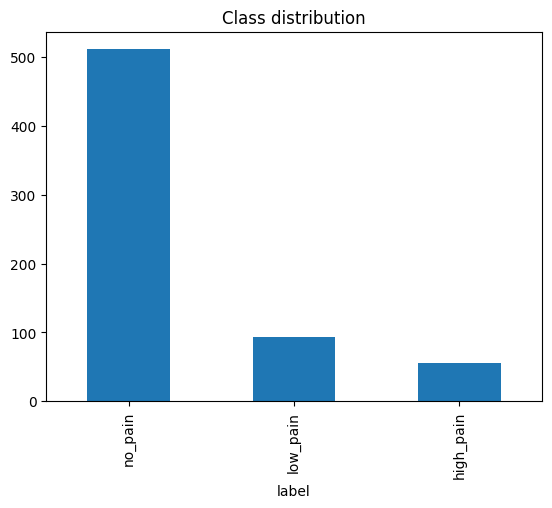

In [305]:
CATEGORICAL_COLUMNS = ['n_legs', 'n_hands', 'n_eyes']
CATEGORY_MAPPINGS: Dict[str, Dict[str, int]] = {}

for col in CATEGORICAL_COLUMNS:
    uniques = pd.concat([X_train_raw[col], X_test_raw[col]]).dropna().unique()
    mapping = {value: idx for idx, value in enumerate(sorted(uniques))}
    CATEGORY_MAPPINGS[col] = mapping
    X_train_raw[col] = X_train_raw[col].map(mapping).astype(np.int32)
    X_test_raw[col] = X_test_raw[col].map(mapping).astype(np.int32)

FEATURE_COLUMNS = [col for col in X_train_raw.columns if col not in ['sample_index', 'time']]

LOW_VARIANCE_THRESHOLD = 2e-3
LOW_MAG_THRESHOLD = 1e-3
HIGH_CORR_THRESHOLD = 0.98

feature_std = X_train_raw[FEATURE_COLUMNS].std()
feature_abs_max = X_train_raw[FEATURE_COLUMNS].abs().max()

# Helper per loggare le feature rimosse

def log_feature_removal(feature: str, reason: str, metric_value: Optional[float] = None, notes: Optional[str] = None):
    entry = {
        'feature': feature,
        'reason': reason,
        'metric': metric_value,
        'notes': notes,
    }
    feature_audit_entries.append(entry)

# Colonne costanti
constant_features = [col for col in FEATURE_COLUMNS if X_train_raw[col].nunique(dropna=False) <= 1]
for feature in constant_features:
    log_feature_removal(feature, 'constant_value', X_train_raw[feature].iloc[0])

# Bassa varianza
low_variance = feature_std[feature_std <= LOW_VARIANCE_THRESHOLD]
for feature, value in low_variance.items():
    log_feature_removal(feature, 'low_variance', float(value))

# Bassa magnitudo
low_magnitude = feature_abs_max[feature_abs_max <= LOW_MAG_THRESHOLD]
for feature, value in low_magnitude.items():
    log_feature_removal(feature, 'low_magnitude', float(value))

# Alta correlazione
corr_matrix = X_train_raw[FEATURE_COLUMNS].corr().abs()
upper_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_corr = corr_matrix.where(upper_mask)
high_corr_features = set()
for col in upper_corr.columns:
    partners = upper_corr.index[upper_corr[col] >= HIGH_CORR_THRESHOLD].tolist()
    if partners:
        high_corr_features.add(col)
        joined_partners = ','.join(partners)
        log_feature_removal(col, 'high_correlation', notes=f'correlated_with={joined_partners}')

# Outlier-dominated features (opzionale, threshold conservativo)
outlier_flagged = outlier_ratio[outlier_ratio['outlier_ratio'] >= 0.75].index.tolist()
for feature in outlier_flagged:
    log_feature_removal(feature, 'extreme_outliers', float(outlier_ratio.loc[feature, 'outlier_ratio']))

features_to_drop = sorted(set(constant_features) | set(low_variance.index) | set(low_magnitude.index) | high_corr_features | set(outlier_flagged))
if features_to_drop:
    print("Removing features:", features_to_drop)
    X_train_raw = X_train_raw.drop(columns=features_to_drop)
    X_test_raw = X_test_raw.drop(columns=features_to_drop)
    FEATURE_COLUMNS = [col for col in FEATURE_COLUMNS if col not in features_to_drop]

    removal_df = pd.DataFrame(feature_audit_entries)
    if not removal_df.empty:
        save_report(removal_df, 'feature_removal_log.csv')
else:
    print('Nessuna feature rimossa con i criteri impostati.')
    removal_df = pd.DataFrame(feature_audit_entries)
    save_report(removal_df, 'feature_removal_log.csv')

FULL_TIME_STEPS = X_train_raw['time'].nunique()
WINDOW_SIZE = 25
WINDOW_STRIDE = 15
EVAL_WINDOW_SIZE = WINDOW_SIZE
EVAL_WINDOW_STRIDE = WINDOW_STRIDE
EVAL_AGGREGATION = 'logsumexp'
if WINDOW_SIZE > FULL_TIME_STEPS:
    raise ValueError(
        f'Requested window size ({WINDOW_SIZE}) exceeds the available time steps ({FULL_TIME_STEPS}).'
    )
TIME_STEPS = FULL_TIME_STEPS

TIME_DIVISOR = max(FULL_TIME_STEPS - 1, 1)
TIME_FEATURE_COLUMNS = ['time_fraction', 'time_sin', 'time_cos', 'time_is_start', 'time_is_end']
for df in (X_train_raw, X_test_raw):
    frac = (df['time'] / TIME_DIVISOR).astype(np.float32)
    df['time_fraction'] = frac
    df['time_sin'] = np.sin(2 * np.pi * frac).astype(np.float32)
    df['time_cos'] = np.cos(2 * np.pi * frac).astype(np.float32)
    df['time_is_start'] = (df['time'] == 0).astype(np.float32)
    df['time_is_end'] = (df['time'] == FULL_TIME_STEPS - 1).astype(np.float32)

for col in TIME_FEATURE_COLUMNS:
    if col not in FEATURE_COLUMNS:
        FEATURE_COLUMNS.append(col)

TEMPORAL_WINDOW_SIZES = (5, 15)

NUMERIC_FEATURE_COLUMNS = [col for col in FEATURE_COLUMNS if col not in CATEGORICAL_COLUMNS]
VALUE_FEATURE_COLUMNS = [col for col in NUMERIC_FEATURE_COLUMNS if col not in TIME_FEATURE_COLUMNS]
ACTIVE_CATEGORICAL_COLUMNS = [col for col in CATEGORICAL_COLUMNS if col in FEATURE_COLUMNS]

CAT_CARDINALITIES = {col: len(CATEGORY_MAPPINGS[col]) for col in ACTIVE_CATEGORICAL_COLUMNS}

def default_embed_dim(cardinality: int) -> int:
    return int(max(2, min(16, np.ceil(cardinality ** 0.25 * 4))))

CAT_EMBED_DIMS = {col: default_embed_dim(size) for col, size in CAT_CARDINALITIES.items()}
CATEGORICAL_CARDINALITY_LIST = [CAT_CARDINALITIES[col] for col in ACTIVE_CATEGORICAL_COLUMNS]
CATEGORICAL_EMBED_DIM_LIST = [CAT_EMBED_DIMS[col] for col in ACTIVE_CATEGORICAL_COLUMNS]
TOTAL_EMBED_DIM = int(sum(CAT_EMBED_DIMS.values()))


def add_temporal_statistics(df: pd.DataFrame):
    if not VALUE_FEATURE_COLUMNS:
        return
    df_signal = df[VALUE_FEATURE_COLUMNS].abs().mean(axis=1)
    df['signal_abs_mean'] = df_signal
    if 'signal_abs_mean' not in FEATURE_COLUMNS:
        FEATURE_COLUMNS.append('signal_abs_mean')
    if 'signal_abs_mean' not in NUMERIC_FEATURE_COLUMNS:
        NUMERIC_FEATURE_COLUMNS.append('signal_abs_mean')
    for window in TEMPORAL_WINDOW_SIZES:
        rolling_mean = (
            df.groupby('sample_index')['signal_abs_mean']
              .transform(lambda x: x.rolling(window, min_periods=1, center=True).mean())
        )
        rolling_std = (
            df.groupby('sample_index')['signal_abs_mean']
              .transform(lambda x: x.rolling(window, min_periods=1, center=True).std().fillna(0.0))
        )
        df[f'signal_mean_w{window}'] = rolling_mean
        df[f'signal_std_w{window}'] = rolling_std
        for feature in (f'signal_mean_w{window}', f'signal_std_w{window}'):
            if feature not in FEATURE_COLUMNS:
                FEATURE_COLUMNS.append(feature)
            if feature not in NUMERIC_FEATURE_COLUMNS:
                NUMERIC_FEATURE_COLUMNS.append(feature)

for dataset in (X_train_raw, X_test_raw):
    add_temporal_statistics(dataset)

NUMERIC_FEATURE_COLUMNS = sorted(NUMERIC_FEATURE_COLUMNS)
NUMERIC_FEATURE_DIM = len(NUMERIC_FEATURE_COLUMNS)
TOTAL_EMBED_DIM = int(sum(CAT_EMBED_DIMS.values()))
MODEL_INPUT_FEATURES = NUMERIC_FEATURE_DIM + TOTAL_EMBED_DIM
NUM_FEATURES = NUMERIC_FEATURE_DIM  # legacy compatibility
NUM_CLASSES = y_train['label'].nunique()
print(
    f"Time steps (raw): {FULL_TIME_STEPS} | Window size: {WINDOW_SIZE} | Numeric features: {NUMERIC_FEATURE_DIM} | "
    f"Categorical embed dim: {TOTAL_EMBED_DIM} | Classes: {NUM_CLASSES}"
)
print('Category mappings:', CATEGORY_MAPPINGS)

y_train['label'].value_counts().plot(kind='bar', title='Class distribution')
plt.show()



In [306]:
# -- Sanity checks per garantire coerenza pipeline ---------------------------
def run_quick_sanity_checks():
    train_cols = set(X_train_raw.columns)
    test_cols = set(X_test_raw.columns)
    assert train_cols == test_cols, 'Train/Test hanno colonne diverse'
    assert len(FEATURE_COLUMNS) == len(set(FEATURE_COLUMNS)), 'FEATURE_COLUMNS contiene duplicati'
    assert all(col in train_cols for col in FEATURE_COLUMNS), 'Colonne feature non presenti nel dataset'
    assert set(NUMERIC_FEATURE_COLUMNS).issubset(train_cols), 'Feature numeriche mancanti nel dataset'
    assert set(ACTIVE_CATEGORICAL_COLUMNS).issubset(train_cols), 'Feature categoriali mancanti nel dataset'
    expected_input = len(NUMERIC_FEATURE_COLUMNS) + sum(CAT_EMBED_DIMS.values())
    assert MODEL_INPUT_FEATURES == expected_input, 'MODEL_INPUT_FEATURES non coerente con le dimensioni calcolate'
    print('Sanity checks superati: dataset e feature set coerenti.')

run_quick_sanity_checks()



Sanity checks superati: dataset e feature set coerenti.


In [307]:
LABEL2IDX = {label: idx for idx, label in enumerate(sorted(y_train['label'].unique()))}
IDX2LABEL = {idx: label for label, idx in LABEL2IDX.items()}
print('Label mapping:', LABEL2IDX)

HIGH_PAIN_LABELS = [label for label in LABEL2IDX if 'high' in label.lower()]
LOW_PAIN_LABELS = [label for label in LABEL2IDX if 'low' in label.lower()]
NO_PAIN_LABELS = [label for label in LABEL2IDX if 'no' in label.lower()]
HIGH_PAIN_IDX = {LABEL2IDX[label] for label in HIGH_PAIN_LABELS}
LOW_PAIN_IDX = {LABEL2IDX[label] for label in LOW_PAIN_LABELS}
NO_PAIN_IDX = {LABEL2IDX[label] for label in NO_PAIN_LABELS}
print('High-pain classes for augmentation:', HIGH_PAIN_LABELS or 'None')
print('Low-pain classes for augmentation:', LOW_PAIN_LABELS or 'None')
print('No-pain classes for augmentation:', NO_PAIN_IDX or 'None')

HIGH_PAIN_OVERSAMPLE = 2 if HIGH_PAIN_IDX else 1
LOW_PAIN_OVERSAMPLE = 2 if LOW_PAIN_IDX else 1
HIGH_PAIN_WEIGHT_SCALE = 0.15
LOW_PAIN_WEIGHT_SCALE = 0.465
NO_PAIN_WEIGHT_SCALE = 2.3
HIGH_PAIN_AUGMENTATION_PARAMS = {
    'jitter_std': 0.03,
    'scale_range': (0.90, 1.10),
    'time_mask_prob': 0.30,
    'time_mask_ratio': 0.12,
    'time_shift_range': 4,
    'time_flip_prob': 0.10,
}
LOW_PAIN_AUGMENTATION_PARAMS = {
    'jitter_std': 0.02,
    'scale_range': (0.95, 1.05),
    'time_mask_prob': 0.20,
    'time_mask_ratio': 0.08,
    'time_shift_range': 3,
    'time_flip_prob': 0.05,
}
AUGMENTATION_PARAMS = HIGH_PAIN_AUGMENTATION_PARAMS


def pivot_timeseries(df: pd.DataFrame, columns: List[str], dtype: np.dtype) -> np.ndarray:
    if not columns:
        raise ValueError('Nessuna colonna fornita per il pivot timeseries.')
    pivoted = (
        df.pivot(index='sample_index', columns='time', values=columns)
          .sort_index(axis=0)
          .sort_index(axis=1, level=1)
    )
    data = pivoted.to_numpy().reshape(-1, TIME_STEPS, len(columns)).astype(dtype)
    return data


X_train_numeric = pivot_timeseries(X_train_raw, NUMERIC_FEATURE_COLUMNS, dtype=np.float32)
X_test_numeric = pivot_timeseries(X_test_raw, NUMERIC_FEATURE_COLUMNS, dtype=np.float32)

if ACTIVE_CATEGORICAL_COLUMNS:
    X_train_categorical = pivot_timeseries(X_train_raw, ACTIVE_CATEGORICAL_COLUMNS, dtype=np.int64)
    X_test_categorical = pivot_timeseries(X_test_raw, ACTIVE_CATEGORICAL_COLUMNS, dtype=np.int64)
else:
    X_train_categorical = None
    X_test_categorical = None

y_train_idx = (
    y_train.set_index('sample_index')
    .loc[pd.unique(X_train_raw['sample_index'])]['label']
    .map(LABEL2IDX)
    .to_numpy()
)

print('Numeric tensors:', X_train_numeric.shape, X_test_numeric.shape)
if X_train_categorical is not None:
    print('Categorical tensors:', X_train_categorical.shape, X_test_categorical.shape)
print('Labels:', y_train_idx.shape)


Label mapping: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
High-pain classes for augmentation: ['high_pain']
Low-pain classes for augmentation: ['low_pain']
No-pain classes for augmentation: {2}
Numeric tensors: (661, 160, 38) (1324, 160, 38)
Categorical tensors: (661, 160, 1) (1324, 160, 1)
Labels: (661,)


In [308]:
class_counts = np.bincount(y_train_idx, minlength=NUM_CLASSES)
class_weights = class_counts.sum() / (class_counts + 1e-6)
class_weights = class_weights / class_weights.mean()
if HIGH_PAIN_IDX:
    for idx in HIGH_PAIN_IDX:
        class_weights[idx] *= HIGH_PAIN_WEIGHT_SCALE
if LOW_PAIN_IDX:
    for idx in LOW_PAIN_IDX:
        class_weights[idx] *= LOW_PAIN_WEIGHT_SCALE
if NO_PAIN_IDX:
    for idx in NO_PAIN_IDX:
        class_weights[idx] *= NO_PAIN_WEIGHT_SCALE
CLASS_COUNTS = class_counts
CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float32)
print('Class counts:', class_counts)
print('Class weights (normalized):', np.round(class_weights, 3))


Class counts: [ 56  94 511]
Class weights (normalized): [0.264 0.487 0.443]


In [309]:
def set_class_weight_scales(high_scale: float, low_scale: float, no_scale: float) -> np.ndarray:
    """Aggiorna gli scale factor globali e ricalcola i pesi di classe normalizzati."""
    global HIGH_PAIN_WEIGHT_SCALE, LOW_PAIN_WEIGHT_SCALE, NO_PAIN_WEIGHT_SCALE, CLASS_WEIGHTS
    HIGH_PAIN_WEIGHT_SCALE = float(high_scale)
    LOW_PAIN_WEIGHT_SCALE = float(low_scale)
    NO_PAIN_WEIGHT_SCALE = float(no_scale)

    class_counts = CLASS_COUNTS
    class_weights = class_counts.sum() / (class_counts + 1e-6)
    class_weights = class_weights / class_weights.mean()
    if HIGH_PAIN_IDX:
        for idx in HIGH_PAIN_IDX:
            class_weights[idx] *= HIGH_PAIN_WEIGHT_SCALE
    if LOW_PAIN_IDX:
        for idx in LOW_PAIN_IDX:
            class_weights[idx] *= LOW_PAIN_WEIGHT_SCALE
    if NO_PAIN_IDX:
        for idx in NO_PAIN_IDX:
            class_weights[idx] *= NO_PAIN_WEIGHT_SCALE
    CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float32)
    return class_weights


def run_weight_scale_search(
    high_values: Sequence[float],
    low_values: Sequence[float],
    no_values: Sequence[float],
    gamma_values: Sequence[float],
    *,
    base_overrides: Optional[Dict[str, Any]] = None,
    max_trials: Optional[int] = None,
    folds: int = 10,
    random_seed: int = SEED,
    save_path: Optional[Path] = None,
    verbose: bool = False,
) -> pd.DataFrame:
    """Esegue una ricerca sistematica/sottocampionata sui weight scale e sul gamma della FocalLoss."""
    combos = list(product(high_values, low_values, no_values, gamma_values))
    rng = random.Random(random_seed)
    rng.shuffle(combos)
    if max_trials is not None:
        combos = combos[:max_trials]

    search_records: List[Dict[str, Any]] = []
    for trial_idx, (high_scale, low_scale, no_scale, gamma) in enumerate(combos, start=1):
        updated_weights = set_class_weight_scales(high_scale, low_scale, no_scale)
        overrides = {
            'focal_gamma': gamma,
            'loss_type': 'focal',
        }
        if base_overrides:
            overrides.update(base_overrides)
        cfg = prepare_config(f"WEIGHT_SEARCH_{trial_idx:03d}", overrides)

        log_path = None
        if save_path is not None:
            save_path.parent.mkdir(parents=True, exist_ok=True)
            log_path = save_path.with_suffix('.log')

        cv_results = run_cross_validation(
            cfg,
            n_splits=folds,
            shuffle=True,
            random_state=random_seed,
            verbose=verbose,
            log_path=log_path,
        )
        fold_scores = [res['best_f1'] for res in cv_results]
        fold_acc = [res['metrics']['accuracy'] for res in cv_results]
        mean_f1 = float(np.mean(fold_scores))
        std_f1 = float(np.std(fold_scores))
        mean_acc = float(np.mean(fold_acc))
        std_acc = float(np.std(fold_acc))

        record = {
            'trial': trial_idx,
            'high_scale': high_scale,
            'low_scale': low_scale,
            'no_scale': no_scale,
            'focal_gamma': gamma,
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'class_weights': updated_weights.tolist(),
        }
        search_records.append(record)

        if save_path is not None and trial_idx % 10 == 0:
            pd.DataFrame(search_records).to_csv(save_path, index=False)

    results_df = pd.DataFrame(search_records).sort_values('mean_f1', ascending=False).reset_index(drop=True)
    if save_path is not None:
        results_df.to_csv(save_path, index=False)
    return results_df



In [310]:
def compute_normalization_stats(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # data shape: (N, T, F)
    num_features = data.shape[-1]
    mean = data.reshape(-1, num_features).mean(axis=0)
    std = data.reshape(-1, num_features).std(axis=0) + 1e-6
    return mean, std


def normalize(data: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (data - mean) / std


feat_mean, feat_std = compute_normalization_stats(X_train_numeric)
X_train_numeric = normalize(X_train_numeric, feat_mean, feat_std)
X_test_numeric = normalize(X_test_numeric, feat_mean, feat_std)



In [311]:
def make_dataloader_from_arrays(
    X_numeric: np.ndarray,
    X_categorical: Optional[np.ndarray],
    y: Optional[np.ndarray],
    batch_size: int,
    shuffle: bool,
    mode: str,
    oversample_factor: int = 1,
    augmentation_params: Optional[Dict[str, float]] = None,
    window_size: Optional[int] = None,
    window_stride: Optional[int] = None,
) -> DataLoader:
    dataset = TimeSeriesDataset(
        numeric_data=X_numeric,
        categorical_data=X_categorical,
        labels=y,
        window_size=window_size,
        window_stride=window_stride,
        mode=mode,
        high_pain_targets=HIGH_PAIN_IDX,
        oversample_factor=oversample_factor,
        augmentation_params=augmentation_params,
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)



In [312]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        numeric_data: np.ndarray,
        categorical_data: Optional[np.ndarray] = None,
        labels: Optional[np.ndarray] = None,
        *,
        window_size: Optional[int] = None,
        window_stride: Optional[int] = None,
        mode: str = 'train',
        high_pain_targets: Optional[set] = None,
        oversample_factor: int = 1,
        augmentation_params: Optional[Dict[str, float]] = None,
    ):
        self.numeric_data = torch.tensor(numeric_data, dtype=torch.float32)
        self.categorical_data = None if categorical_data is None else torch.tensor(categorical_data, dtype=torch.long)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
        self.window_size = window_size
        self.window_stride = max(1, window_stride or 1)
        self.mode = mode
        self.high_pain_targets = set(high_pain_targets or [])
        self.augmentation_params = augmentation_params or {}
        self.time_steps = self.numeric_data.shape[1]

        if mode not in {'train', 'valid', 'test'}:
            raise ValueError(f"Unsupported mode '{mode}'. Use 'train', 'valid', or 'test'.")
        if self.window_size is not None and self.window_size > self.time_steps:
            raise ValueError(
                f'Window size {self.window_size} exceeds series length {self.time_steps}.'
            )

        self.indices = self._build_indices(max(1, oversample_factor))

    def _build_indices(self, oversample_factor: int) -> List[int]:
        base_indices = list(range(len(self.numeric_data)))
        if (
            self.labels is None
            or not self.high_pain_targets
            or oversample_factor <= 1
        ):
            return base_indices

        high_indices = [idx for idx in base_indices if int(self.labels[idx].item()) in self.high_pain_targets]
        if not high_indices:
            return base_indices

        extra_indices: List[int] = []
        for _ in range(oversample_factor - 1):
            extra_indices.extend(high_indices)
        return base_indices + extra_indices

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        real_idx = self.indices[idx]
        series_numeric = self.numeric_data[real_idx]
        series_categorical = None if self.categorical_data is None else self.categorical_data[real_idx]
        label = None if self.labels is None else self.labels[real_idx]

        if self.window_size is not None and self.mode == 'train':
            series_numeric = self._select_window(series_numeric, random_selection=True)
            if series_categorical is not None:
                series_categorical = self._select_window(series_categorical, random_selection=True)
        elif self.window_size is not None:
            series_numeric = self._select_window(series_numeric, random_selection=False)
            if series_categorical is not None:
                series_categorical = self._select_window(series_categorical, random_selection=False)
        else:
            series_numeric = series_numeric.clone()
            if series_categorical is not None:
                series_categorical = series_categorical.clone()

        if (
            self.mode == 'train'
            and label is not None
            and int(label.item()) in self.high_pain_targets
            and self.augmentation_params
        ):
            series_numeric = self._augment(series_numeric)

        if label is None:
            return series_numeric, series_categorical
        return series_numeric, series_categorical, label

    def _select_window(self, series: torch.Tensor, *, random_selection: bool) -> torch.Tensor:
        window = self.window_size or series.shape[0]
        if window >= series.shape[0]:
            return series.clone()

        max_start = series.shape[0] - window
        if max_start <= 0:
            start = 0
        else:
            stride = max(1, self.window_stride)
            positions = list(range(0, max_start + 1, stride))
            if positions[-1] != max_start:
                positions.append(max_start)
            start = random.choice(positions) if random_selection else positions[len(positions) // 2]
        end = start + window
        return series[start:end].clone()

    def _augment(self, series: torch.Tensor) -> torch.Tensor:
        augmented = series.clone()
        jitter_std = float(self.augmentation_params.get('jitter_std', 0.0))
        if jitter_std > 0:
            augmented = augmented + torch.randn_like(augmented) * jitter_std

        scale_range = self.augmentation_params.get('scale_range')
        if scale_range:
            low, high = scale_range
            scale = random.uniform(low, high)
            augmented = augmented * scale

        time_shift_range = int(self.augmentation_params.get('time_shift_range', 0))
        if time_shift_range > 0:
            shift = random.randint(-time_shift_range, time_shift_range)
            if shift != 0:
                augmented = torch.roll(augmented, shifts=shift, dims=0)

        if random.random() < float(self.augmentation_params.get('time_flip_prob', 0.0)):
            augmented = torch.flip(augmented, dims=[0])

        time_mask_prob = float(self.augmentation_params.get('time_mask_prob', 0.0))
        time_mask_ratio = float(self.augmentation_params.get('time_mask_ratio', 0.0))
        if time_mask_prob > 0 and time_mask_ratio > 0 and random.random() < time_mask_prob:
            mask_len = max(1, int(augmented.shape[0] * time_mask_ratio))
            if mask_len < augmented.shape[0]:
                start = random.randint(0, augmented.shape[0] - mask_len)
                augmented[start:start + mask_len] = 0.0

        return augmented



In [313]:
def extract_sliding_windows(series: torch.Tensor, window_size: int, stride: Optional[int]) -> torch.Tensor:
    """Return a stack of sliding windows for a single time-series tensor."""
    if window_size <= 0:
        raise ValueError('window_size must be a positive integer.')

    series_length = series.shape[0]
    if window_size >= series_length:
        return series.unsqueeze(0)

    step = max(1, int(stride or window_size))
    max_start = series_length - window_size
    starts = list(range(0, max_start + 1, step))
    if starts[-1] != max_start:
        starts.append(max_start)

    windows = [series[start:start + window_size] for start in starts]
    return torch.stack(windows, dim=0)


class FocalLoss(nn.Module):
    def __init__(
        self,
        gamma: float = 2.0,
        weight: Optional[torch.Tensor] = None,
        reduction: str = 'mean',
        eps: float = 1e-6,
    ):
        super().__init__()
        self.gamma = float(gamma)
        self.reduction = reduction
        self.eps = eps
        if weight is not None:
            self.register_buffer('weight', weight.clone().detach())
        else:
            self.register_buffer('weight', None)

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if inputs.ndim < 2:
            raise ValueError('FocalLoss expects inputs of shape (N, C, ...)')

        log_probs = F.log_softmax(inputs, dim=-1)
        probs = log_probs.exp()
        one_hot = F.one_hot(targets, num_classes=log_probs.size(-1)).type_as(log_probs)
        pt = (probs * one_hot).sum(dim=-1).clamp(min=self.eps)
        focal_factor = (1.0 - pt) ** self.gamma
        log_pt = (log_probs * one_hot).sum(dim=-1)
        loss = -focal_factor * log_pt

        if self.weight is not None:
            class_weights = self.weight.to(inputs.device)
            loss = loss * class_weights[targets]

        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        if self.reduction == 'none':
            return loss
        raise ValueError(f"Unsupported reduction '{self.reduction}' for FocalLoss")


def build_loss_fn(config: Dict[str, Any]) -> nn.Module:
    """Factory per la funzione di loss in base alla configurazione."""
    loss_type = (config.get('loss_type') or 'ce').lower()
    reduction = config.get('loss_reduction', 'mean')
    label_smoothing = float(config.get('label_smoothing', 0.0))
    weight = CLASS_WEIGHTS.clone().detach() if config.get('use_class_weights', False) else None

    if loss_type in {'focal', 'focal_loss'}:
        gamma = float(config.get('focal_gamma', 2.0))
        return FocalLoss(gamma=gamma, weight=weight, reduction=reduction)
    if loss_type in {'ce', 'cross_entropy'}:
        return nn.CrossEntropyLoss(weight=weight, label_smoothing=label_smoothing, reduction=reduction)

    raise ValueError(f"Unsupported loss_type '{config.get('loss_type')}'")


In [314]:
class TemporalAttentionPooling(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, dropout: float = 0.0):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
        )
        self.score = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, time, features)
        attn_logits = self.score(self.proj(x))  # (batch, time, 1)
        attn_weights = torch.softmax(attn_logits, dim=1)
        context = (attn_weights * x).sum(dim=1)
        return context



In [315]:
def forward_with_sliding_windows(
    model: nn.Module,
    inputs_numeric: torch.Tensor,
    inputs_categorical: Optional[torch.Tensor],
    window_size: Optional[int],
    stride: Optional[int],
    aggregation: str = 'max',
) -> torch.Tensor:
    if window_size is None or window_size >= inputs_numeric.shape[1]:
        return model(inputs_numeric, inputs_categorical)

    all_windows_num: List[torch.Tensor] = []
    all_windows_cat: List[torch.Tensor] = [] if inputs_categorical is not None else []
    window_counts: List[int] = []
    for idx in range(inputs_numeric.shape[0]):
        sample_num = inputs_numeric[idx]
        num_windows = extract_sliding_windows(sample_num, window_size, stride)
        all_windows_num.append(num_windows)
        if inputs_categorical is not None:
            sample_cat = inputs_categorical[idx]
            cat_windows = extract_sliding_windows(sample_cat, window_size, stride)
            all_windows_cat.append(cat_windows)
        window_counts.append(num_windows.shape[0])

    stacked_num = torch.cat(all_windows_num, dim=0)
    stacked_cat = torch.cat(all_windows_cat, dim=0) if inputs_categorical is not None else None
    logits = model(stacked_num, stacked_cat)
    chunks = logits.split(window_counts, dim=0)

    aggregated_logits: List[torch.Tensor] = []
    aggregation = aggregation.lower()
    for chunk in chunks:
        if aggregation == 'max':
            aggregated_logits.append(chunk.max(dim=0).values)
        elif aggregation == 'mean':
            aggregated_logits.append(chunk.mean(dim=0))
        elif aggregation == 'logsumexp':
            aggregated_logits.append(torch.logsumexp(chunk, dim=0))
        else:
            raise ValueError(f"Unsupported aggregation '{aggregation}'.")

    return torch.stack(aggregated_logits, dim=0)


In [316]:
def create_dataloaders(
    X_numeric: np.ndarray,
    X_categorical: Optional[np.ndarray],
    y: np.ndarray,
    valid_size: float = 0.2,
    batch_size: int = 128,
    oversample_factor: int = HIGH_PAIN_OVERSAMPLE,
    window_size: Optional[int] = WINDOW_SIZE,
    window_stride: Optional[int] = WINDOW_STRIDE,
    augmentation_params: Optional[Dict[str, float]] = AUGMENTATION_PARAMS,
):
    if X_categorical is not None:
        X_train_num, X_valid_num, X_train_cat, X_valid_cat, y_train, y_valid = train_test_split(
            X_numeric,
            X_categorical,
            y,
            test_size=valid_size,
            random_state=SEED,
            stratify=y,
        )
    else:
        X_train_num, X_valid_num, y_train, y_valid = train_test_split(
            X_numeric,
            y,
            test_size=valid_size,
            random_state=SEED,
            stratify=y,
        )
        X_train_cat = X_valid_cat = None

    train_loader = make_dataloader_from_arrays(
        X_train_num,
        X_train_cat,
        y_train,
        batch_size=batch_size,
        shuffle=True,
        mode='train',
        oversample_factor=oversample_factor,
        augmentation_params=augmentation_params,
        window_size=window_size,
        window_stride=window_stride,
    )
    valid_loader = make_dataloader_from_arrays(
        X_valid_num,
        X_valid_cat,
        y_valid,
        batch_size=batch_size,
        shuffle=False,
        mode='valid',
        window_size=None,
        window_stride=None,
    )
    return train_loader, valid_loader, (X_train_num, X_train_cat, y_train, X_valid_num, X_valid_cat, y_valid)


BATCH_SIZE = 128
train_loader, valid_loader, (X_train_split, X_train_cat_split, y_train_split, X_valid_split, X_valid_cat_split, y_valid_split) = create_dataloaders(
    X_train_numeric,
    X_train_categorical,
    y_train_idx,
    batch_size=BATCH_SIZE,
)



In [317]:
class RecurrentBackbone(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
        rnn_type: str = 'lstm',
        bidirectional: bool = True,
        conv_layers: int = 0,
        conv_channels: Optional[int] = None,
        conv_kernel_size: int = 3,
        conv_dropout: float = 0.1,
        categorical_cardinalities: Optional[List[int]] = None,
        categorical_embed_dims: Optional[List[int]] = None,
        attention_type: str = 'additive',
        attention_hidden_dim: int = 128,
    ):
        super().__init__()
        if conv_kernel_size % 2 == 0:
            raise ValueError('conv_kernel_size should be odd to preserve temporal dimension.')
        rnn_cls = {
            'rnn': nn.RNN,
            'gru': nn.GRU,
            'lstm': nn.LSTM,
        }[rnn_type.lower()]
        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional

        self.categorical_cardinalities = categorical_cardinalities or []
        self.categorical_embed_dims = categorical_embed_dims or []
        if self.categorical_cardinalities:
            assert len(self.categorical_cardinalities) == len(self.categorical_embed_dims), 'Mismatch tra cardinalità ed embed dims.'
            self.cat_embeddings = nn.ModuleList([
                nn.Embedding(cardinality, embed_dim)
                for cardinality, embed_dim in zip(self.categorical_cardinalities, self.categorical_embed_dims)
            ])
        else:
            self.cat_embeddings = nn.ModuleList()

        self.attention_type = (attention_type or 'none').lower()
        self.attention_pool = None

        self.conv_layers = conv_layers
        self.conv = None
        rnn_input_size = input_size
        if conv_layers > 0:
            conv_blocks: List[nn.Module] = []
            in_channels = input_size
            out_channels = conv_channels or input_size
            for layer_idx in range(conv_layers):
                conv_blocks.append(
                    nn.Conv1d(
                        in_channels,
                        out_channels,
                        kernel_size=conv_kernel_size,
                        padding=conv_kernel_size // 2,
                        bias=False,
                    )
                )
                conv_blocks.append(nn.BatchNorm1d(out_channels))
                conv_blocks.append(nn.ReLU())
                if conv_dropout > 0:
                    conv_blocks.append(nn.Dropout(conv_dropout))
                in_channels = out_channels
            self.conv = nn.Sequential(*conv_blocks)
            rnn_input_size = out_channels

        self.rnn = rnn_cls(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional,
        )
        proj_input = hidden_size * (2 if bidirectional else 1)
        if self.attention_type == 'additive':
            self.attention_pool = TemporalAttentionPooling(
                proj_input,
                hidden_dim=attention_hidden_dim,
                dropout=dropout,
            )
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(proj_input, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, NUM_CLASSES),
        )

    def forward(self, x_numeric: torch.Tensor, x_categorical: Optional[torch.Tensor] = None):
        x = x_numeric
        if self.cat_embeddings:
            if x_categorical is None:
                raise ValueError('Input categoriali mancanti per il modello con embedding.')
            embedded_features = []
            for idx, embedding in enumerate(self.cat_embeddings):
                embedded_features.append(embedding(x_categorical[..., idx]))
            cat_tensor = torch.cat(embedded_features, dim=-1)
            x = torch.cat([x, cat_tensor], dim=-1)

        if self.conv is not None:
            x = x.transpose(1, 2)
            x = self.conv(x)
            x = x.transpose(1, 2)
        out, _ = self.rnn(x)
        if self.attention_pool is not None:
            pooled = self.attention_pool(out)
        elif self.attention_type == 'mean':
            pooled = out.mean(dim=1)
        else:
            pooled = out[:, -1, :]
        return self.head(pooled)


In [318]:
def compute_classification_metrics(preds: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    accuracy = float((preds == targets).mean())
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets,
        preds,
        average='macro',
        zero_division=0,
    )
    return {
        'accuracy': accuracy,
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: GradScaler,
    max_grad_norm: float = 5.0,
) -> Tuple[float, Dict[str, float]]:
    model.train()
    running_loss = 0.0
    preds_all, targets_all = [], []
    grad_norm_values: List[float] = []

    for inputs_numeric, inputs_categorical, targets in loader:
        inputs_numeric = inputs_numeric.to(DEVICE)
        inputs_categorical = inputs_categorical.to(DEVICE) if inputs_categorical is not None else None
        targets = targets.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with autocast_context():
            logits = model(inputs_numeric, inputs_categorical)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        if max_grad_norm is not None:
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            if torch.isfinite(grad_norm):
                grad_norm_values.append(float(grad_norm.detach().cpu()))
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs_numeric.size(0)
        preds_all.append(torch.argmax(logits.detach(), dim=1).cpu())
        targets_all.append(targets.cpu())

    preds_np = torch.cat(preds_all).numpy()
    targets_np = torch.cat(targets_all).numpy()
    metrics = compute_classification_metrics(preds_np, targets_np)
    if grad_norm_values:
        metrics['grad_norm'] = float(np.mean(grad_norm_values))
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, metrics


def evaluate_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    eval_window_size: Optional[int],
    eval_window_stride: Optional[int],
    aggregation: str,
) -> Tuple[float, Dict[str, float], np.ndarray, np.ndarray]:
    model.eval()
    running_loss = 0.0
    preds_all, targets_all = [], []

    with torch.no_grad():
        for inputs_numeric, inputs_categorical, targets in loader:
            inputs_numeric = inputs_numeric.to(DEVICE)
            inputs_categorical = inputs_categorical.to(DEVICE) if inputs_categorical is not None else None
            targets = targets.to(DEVICE)
            with autocast_context():
                logits = forward_with_sliding_windows(
                    model,
                    inputs_numeric,
                    inputs_categorical,
                    eval_window_size,
                    eval_window_stride,
                    aggregation,
                )
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)
            preds_all.append(torch.argmax(logits, dim=1).cpu())
            targets_all.append(targets.cpu())

    preds_np = torch.cat(preds_all).numpy()
    targets_np = torch.cat(targets_all).numpy()
    metrics = compute_classification_metrics(preds_np, targets_np)
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, metrics, preds_np, targets_np



In [319]:
def create_dataloaders_3way(
    X_numeric: np.ndarray,
    X_categorical: Optional[np.ndarray],
    y: np.ndarray,
    batch_size: int = 128,
    oversample_factor: int = HIGH_PAIN_OVERSAMPLE,
    window_size: Optional[int] = WINDOW_SIZE,
    window_stride: Optional[int] = WINDOW_STRIDE,
    augmentation_params: Optional[Dict[str, float]] = AUGMENTATION_PARAMS,
    random_state: int = SEED,
) -> Tuple[DataLoader, DataLoader, DataLoader, Tuple]:
    """Crea DataLoader per train/valid/test con split 80/10/10 stratificato."""
    # 80% train, 20% temp
    if X_categorical is not None:
        X_train_num, X_temp_num, X_train_cat, X_temp_cat, y_train, y_temp = train_test_split(
            X_numeric,
            X_categorical,
            y,
            test_size=0.20,
            random_state=random_state,
            stratify=y,
        )
        # split temp 50/50 in valid/test
        X_valid_num, X_test_num, X_valid_cat, X_test_cat, y_valid, y_test = train_test_split(
            X_temp_num,
            X_temp_cat,
            y_temp,
            test_size=0.50,
            random_state=random_state,
            stratify=y_temp,
        )
    else:
        X_train_num, X_temp_num, y_train, y_temp = train_test_split(
            X_numeric,
            y,
            test_size=0.20,
            random_state=random_state,
            stratify=y,
        )
        X_valid_num, X_test_num, y_valid, y_test = train_test_split(
            X_temp_num,
            y_temp,
            test_size=0.50,
            random_state=random_state,
            stratify=y_temp,
        )
        X_train_cat = X_valid_cat = X_test_cat = None

    train_loader = make_dataloader_from_arrays(
        X_train_num,
        X_train_cat,
        y_train,
        batch_size=batch_size,
        shuffle=True,
        mode='train',
        oversample_factor=oversample_factor,
        augmentation_params=augmentation_params,
        window_size=window_size,
        window_stride=window_stride,
    )
    valid_loader = make_dataloader_from_arrays(
        X_valid_num,
        X_valid_cat,
        y_valid,
        batch_size=batch_size,
        shuffle=False,
        mode='valid',
        window_size=None,
        window_stride=None,
    )
    test_loader = make_dataloader_from_arrays(
        X_test_num,
        X_test_cat,
        y_test,
        batch_size=batch_size,
        shuffle=False,
        mode='valid',
        window_size=None,
        window_stride=None,
    )

    return (
        train_loader,
        valid_loader,
        test_loader,
        (X_train_num, X_train_cat, y_train, X_valid_num, X_valid_cat, y_valid, X_test_num, X_test_cat, y_test),
    )


In [320]:
# Override di run_experiment per usare split 80/10/10 e valutazione test

def run_experiment(config: Dict) -> Dict:
    run_name = config.get('run_name') or f"{config['rnn_type'].upper()}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    config = copy.deepcopy(config)
    config['run_name'] = run_name

    train_loader, valid_loader, test_loader, split = create_dataloaders_3way(
        X_train_numeric,
        X_train_categorical,
        y_train_idx,
        batch_size=config['batch_size'],
        oversample_factor=config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
        window_size=config.get('window_size', WINDOW_SIZE),
        window_stride=config.get('window_stride', WINDOW_STRIDE),
        augmentation_params=config.get('augmentation_params', AUGMENTATION_PARAMS),
    )
    (X_tr_num, X_tr_cat, y_tr, X_val_num, X_val_cat, y_val, X_te_num, X_te_cat, y_te) = split

    model, history, best_state = fit_model(
        config,
        train_loader,
        valid_loader,
        run_name=run_name,
        tensorboard=config.get('tensorboard', True),
    )

    best_state['data_split'] = {
        'X_train_num': X_tr_num,
        'X_train_cat': X_tr_cat,
        'y_train': y_tr,
        'X_valid_num': X_val_num,
        'X_valid_cat': X_val_cat,
        'y_valid': y_val,
        'X_test_num': X_te_num,
        'X_test_cat': X_te_cat,
        'y_test': y_te,
    }
    best_state['model'] = model
    best_state['history'] = history

    # Test evaluation
    model.eval()
    all_logits = []
    all_targets = []
    eval_window_size = config.get('eval_window_size', EVAL_WINDOW_SIZE)
    eval_window_stride = config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
    eval_aggregation = config.get('eval_aggregation', EVAL_AGGREGATION)
    with torch.no_grad():
        for inputs_numeric, inputs_categorical, targets in test_loader:
            inputs_numeric = inputs_numeric.to(DEVICE)
            inputs_categorical = inputs_categorical.to(DEVICE) if inputs_categorical is not None else None
            targets = targets.to(DEVICE)
            with autocast_context():
                logits = forward_with_sliding_windows(
                    model,
                    inputs_numeric,
                    inputs_categorical,
                    eval_window_size,
                    eval_window_stride,
                    eval_aggregation,
                )
            all_logits.append(logits.cpu())
            all_targets.append(targets.cpu())
    logits_cat = torch.cat(all_logits, dim=0)
    targets_np = torch.cat(all_targets, dim=0).numpy()
    preds_np = torch.argmax(logits_cat, dim=1).numpy()
    test_metrics = compute_classification_metrics(preds_np, targets_np)
    best_state['test_preds'] = preds_np
    best_state['test_targets'] = targets_np
    best_state['test_metrics'] = test_metrics

    return best_state


In [321]:
def fit_model(
    config: Dict,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    run_name: str,
    tensorboard: bool = True,
) -> Tuple[nn.Module, Dict[str, List[float]], Dict]:
    model = RecurrentBackbone(
        input_size=MODEL_INPUT_FEATURES,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        rnn_type=config['rnn_type'],
        bidirectional=config.get('bidirectional', False),
        conv_layers=config.get('conv_layers', 0),
        conv_channels=config.get('conv_channels'),
        conv_kernel_size=config.get('conv_kernel_size', 3),
        conv_dropout=config.get('conv_dropout', 0.1),
        categorical_cardinalities=CATEGORICAL_CARDINALITY_LIST,
        categorical_embed_dims=CATEGORICAL_EMBED_DIM_LIST,
    ).to(DEVICE)

    criterion = build_loss_fn(config).to(DEVICE)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['lr'],
        weight_decay=config.get('weight_decay', 0.0),
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=config.get('scheduler_factor', 0.5),
        patience=config.get('scheduler_patience', 3),
    )
    scaler = create_grad_scaler()

    history: Dict[str, List[float]] = {
        'train_loss': [],
        'train_accuracy': [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'train_grad_norm': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_f1': [],
        'valid_precision': [],
        'valid_recall': [],
        'lr': [],
    }

    run_log_dir = (LOG_DIR / run_name).resolve()
    writer = SummaryWriter(run_log_dir.as_posix()) if tensorboard else None

    best_metric = -np.inf
    best_state: Optional[Dict] = None
    patience = config.get('patience', 10)
    patience_counter = 0
    checkpoint_path = (CHECKPOINT_DIR / f'{run_name}.pt').resolve()

    eval_window_size = config.get('eval_window_size', EVAL_WINDOW_SIZE)
    eval_window_stride = config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
    eval_aggregation = config.get('eval_aggregation', EVAL_AGGREGATION)

    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_metrics = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            max_grad_norm=config.get('max_grad_norm', 5.0),
        )
        valid_loss, valid_metrics, preds, targets = evaluate_epoch(
            model,
            valid_loader,
            criterion,
            eval_window_size,
            eval_window_stride,
            eval_aggregation,
        )
        scheduler.step(valid_metrics['f1'])

        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['train_precision'].append(train_metrics['precision'])
        history['train_recall'].append(train_metrics['recall'])
        history['train_grad_norm'].append(train_metrics.get('grad_norm', 0.0))
        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(valid_metrics['accuracy'])
        history['valid_f1'].append(valid_metrics['f1'])
        history['valid_precision'].append(valid_metrics['precision'])
        history['valid_recall'].append(valid_metrics['recall'])
        history['lr'].append(current_lr)

        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/valid', valid_loss, epoch)
            writer.add_scalar('F1/train', train_metrics['f1'], epoch)
            writer.add_scalar('F1/valid', valid_metrics['f1'], epoch)
            writer.add_scalar('Accuracy/train', train_metrics['accuracy'], epoch)
            writer.add_scalar('Accuracy/valid', valid_metrics['accuracy'], epoch)
            writer.add_scalar('GradNorm/train', train_metrics.get('grad_norm', 0.0), epoch)
            writer.add_scalar('LearningRate', current_lr, epoch)

        msg = (
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} acc={train_metrics['accuracy']:.3f} f1={train_metrics['f1']:.3f} | "
            f"valid_loss={valid_loss:.4f} acc={valid_metrics['accuracy']:.3f} f1={valid_metrics['f1']:.3f} | "
            f"lr={current_lr:.2e}"
        )
        print(msg)

        if valid_metrics['f1'] > best_metric + config.get('min_improvement', 0.0):
            best_metric = valid_metrics['f1']
            patience_counter = 0
            best_state = {
                'epoch': epoch,
                'model_state': copy.deepcopy(model.state_dict()),
                'optimizer_state': copy.deepcopy(optimizer.state_dict()),
                'metrics': valid_metrics,
                'train_metrics': train_metrics,
                'preds': preds,
                'targets': targets,
            }
            torch.save(best_state['model_state'], checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best f1={best_metric:.4f}.")
                break

    if writer is not None:
        writer.close()

    if best_state is None:
        best_state = {
            'epoch': config['epochs'],
            'model_state': copy.deepcopy(model.state_dict()),
            'optimizer_state': copy.deepcopy(optimizer.state_dict()),
            'metrics': valid_metrics,
            'train_metrics': train_metrics,
            'preds': preds,
            'targets': targets,
        }
        torch.save(best_state['model_state'], checkpoint_path)

    model.load_state_dict(best_state['model_state'])
    best_state.update(
        {
            'run_name': run_name,
            'config': copy.deepcopy(config),
            'history': history,
            'checkpoint_path': checkpoint_path,
            'best_f1': best_metric,
        }
    )
    return model, history, best_state



In [322]:
def run_cross_validation(
    config: Dict,
    n_splits: int = 5,
    shuffle: bool = True,
    random_state: int = SEED,
    verbose: bool = True,
    log_path: Optional[Path] = None,
) -> List[Dict]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    fold_results: List[Dict] = []

    def _log(message: str) -> None:
        if verbose:
            print(message)
        if log_path is not None:
            log_path.parent.mkdir(parents=True, exist_ok=True)
            with log_path.open('a', encoding='utf-8') as fp:
                fp.write(message + '\n')

    _log(
        f"\n>>> Starting {n_splits}-fold CV for {config['run_name']} ({config['rnn_type'].upper()})"
    )
    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X_train_numeric, y_train_idx), start=1):
        fold_config = copy.deepcopy(config)
        fold_config['run_name'] = f"{config['run_name']}_fold{fold_idx}"

        X_tr_num, X_val_num = X_train_numeric[train_idx], X_train_numeric[valid_idx]
        if X_train_categorical is not None:
            X_tr_cat, X_val_cat = X_train_categorical[train_idx], X_train_categorical[valid_idx]
        else:
            X_tr_cat = X_val_cat = None
        y_tr, y_val = y_train_idx[train_idx], y_train_idx[valid_idx]

        train_loader = make_dataloader_from_arrays(
            X_tr_num,
            X_tr_cat,
            y_tr,
            batch_size=fold_config['batch_size'],
            shuffle=True,
            mode='train',
            oversample_factor=fold_config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
            augmentation_params=fold_config.get('augmentation_params', AUGMENTATION_PARAMS),
            window_size=fold_config.get('window_size', WINDOW_SIZE),
            window_stride=fold_config.get('window_stride', WINDOW_STRIDE),
        )
        valid_loader = make_dataloader_from_arrays(
            X_val_num,
            X_val_cat,
            y_val,
            batch_size=fold_config['batch_size'],
            shuffle=False,
            mode='valid',
            window_size=None,
            window_stride=None,
        )

        model, history, best_state = fit_model(
            fold_config,
            train_loader,
            valid_loader,
            run_name=fold_config['run_name'],
            tensorboard=fold_config.get('tensorboard', True),
        )
        best_state['fold'] = fold_idx
        best_state['model'] = model
        best_state['history'] = history
        fold_results.append(best_state)

        metrics = best_state['metrics']
        _log(
            f"Fold {fold_idx}/{n_splits} | best F1={metrics['f1']:.4f} | "
            f"Accuracy={metrics['accuracy']:.4f}"
        )

    return fold_results


In [323]:
def run_smoke_test(
    *,
    epochs: int = 3,
    batch_size: int = 64,
    window_size: int = WINDOW_SIZE,
    attention: str = 'additive',
) -> Dict:
    """Esegue un training rapidissimo per verificare che la pipeline funzioni."""
    overrides = {
        'run_name': f'SMOKE_TEST_{datetime.now().strftime("%H%M%S")}',
        'epochs': epochs,
        'batch_size': batch_size,
        'patience': max(2, epochs // 2),
        'tensorboard': False,
        'window_size': window_size,
        'eval_window_size': window_size,
        'attention_type': attention,
        'attention_hidden_dim': 64,
    }
    cfg = prepare_config('SMOKE_TEST', overrides)
    result = run_experiment(cfg)
    print(
        f"Smoke test F1={result['best_f1']:.4f} | Acc={result['metrics']['accuracy']:.4f} | "
        f"Epoch={result['epoch']}"
    )
    return result



In [324]:
def summarize_cv_results(cv_results: List[Dict]) -> pd.DataFrame:
    rows = []
    for res in cv_results:
        cfg = res['config']
        metrics = res['metrics']
        rows.append({
            'run_name': res['run_name'],
            'fold': res['fold'],
            'rnn_type': cfg['rnn_type'],
            'bidirectional': cfg.get('bidirectional', False),
            'hidden_size': cfg['hidden_size'],
            'num_layers': cfg['num_layers'],
            'dropout': cfg['dropout'],
            'f1': metrics['f1'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'checkpoint': str(res['checkpoint_path']),
            'log_dir': str(LOG_DIR / res['run_name']),
        })

    df = pd.DataFrame(rows)
    agg = df.groupby(['rnn_type', 'bidirectional'])[['f1', 'accuracy', 'precision', 'recall']].agg(['mean', 'std'])
    agg.columns = ['_'.join(col) for col in agg.columns]
    agg = agg.reset_index()
    return df, agg



In [325]:
from sklearn.model_selection import StratifiedShuffleSplit


def stratified_train_test_split_arrays(
    X_num: np.ndarray,
    X_cat: Optional[np.ndarray],
    y: np.ndarray,
    test_size: float = 0.1,
    random_state: int = SEED,
):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    (train_idx, test_idx), = splitter.split(X_num, y)
    X_tr_num, X_te_num = X_num[train_idx], X_num[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    if X_cat is not None:
        X_tr_cat, X_te_cat = X_cat[train_idx], X_cat[test_idx]
    else:
        X_tr_cat = X_te_cat = None
    return X_tr_num, X_tr_cat, y_tr, X_te_num, X_te_cat, y_te


def run_cross_validation_on_arrays(
    config: Dict,
    X_num: np.ndarray,
    X_cat: Optional[np.ndarray],
    y: np.ndarray,
    n_splits: int = 5,
    shuffle: bool = True,
    random_state: int = SEED,
    verbose: bool = True,
    log_path: Optional[Path] = None,
    X_te_num: Optional[np.ndarray] = None,
    X_te_cat: Optional[np.ndarray] = None,
    y_te: Optional[np.ndarray] = None,
) -> List[Dict]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    fold_results: List[Dict] = []

    def _log(message: str) -> None:
        if verbose:
            print(message)
        if log_path is not None:
            log_path.parent.mkdir(parents=True, exist_ok=True)
            with log_path.open('a', encoding='utf-8') as fp:
                fp.write(message + '\n')

    _log(f"\n>>> Starting {n_splits}-fold CV for {config['run_name']} ({config['rnn_type'].upper()}) on TRAIN portion")
    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X_num, y), start=1):
        fold_config = copy.deepcopy(config)
        fold_config['run_name'] = f"{config['run_name']}_fold{fold_idx}"

        X_tr_num, X_val_num = X_num[train_idx], X_num[valid_idx]
        if X_cat is not None:
            X_tr_cat, X_val_cat = X_cat[train_idx], X_cat[valid_idx]
        else:
            X_tr_cat = X_val_cat = None
        y_tr, y_val = y[train_idx], y[valid_idx]

        train_loader = make_dataloader_from_arrays(
            X_tr_num,
            X_tr_cat,
            y_tr,
            batch_size=fold_config['batch_size'],
            shuffle=True,
            mode='train',
            oversample_factor=fold_config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
            augmentation_params=fold_config.get('augmentation_params', AUGMENTATION_PARAMS),
            window_size=fold_config.get('window_size', WINDOW_SIZE),
            window_stride=fold_config.get('window_stride', WINDOW_STRIDE),
        )
        valid_loader = make_dataloader_from_arrays(
            X_val_num,
            X_val_cat,
            y_val,
            batch_size=fold_config['batch_size'],
            shuffle=False,
            mode='valid',
            window_size=None,
            window_stride=None,
        )

        model, history, best_state = fit_model(
            fold_config,
            train_loader,
            valid_loader,
            run_name=fold_config['run_name'],
            tensorboard=fold_config.get('tensorboard', True),
        )
        best_state['fold'] = fold_idx
        best_state['model'] = model
        best_state['history'] = history

        # If an external TEST set is provided, evaluate this fold's model on it
        if X_te_num is not None and y_te is not None:
            ext = evaluate_on_external_test(
                model,
                X_te_num,
                X_te_cat,
                y_te,
                config=fold_config,
            )
            best_state.update(ext)

        fold_results.append(best_state)

        metrics = best_state['metrics']
        msg = (
            f"Fold {fold_idx}/{n_splits} | best F1(valid)={metrics['f1']:.4f} | "
            f"Accuracy(valid)={metrics['accuracy']:.4f}"
        )
        if 'test_metrics' in best_state:
            msg += f" | Test F1={best_state['test_metrics']['f1']:.4f}"
        _log(msg)

    return fold_results


def evaluate_on_external_test(
    model: nn.Module,
    X_te_num: np.ndarray,
    X_te_cat: Optional[np.ndarray],
    y_te: np.ndarray,
    *,
    config: Dict,
) -> Dict[str, Any]:
    test_loader = make_dataloader_from_arrays(
        X_te_num,
        X_te_cat,
        y_te,
        batch_size=256,
        shuffle=False,
        mode='valid',
        window_size=None,
        window_stride=None,
    )

    model.eval()
    all_logits = []
    all_targets = []
    eval_window_size = config.get('eval_window_size', EVAL_WINDOW_SIZE)
    eval_window_stride = config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
    eval_aggregation = config.get('eval_aggregation', EVAL_AGGREGATION)
    with torch.no_grad():
        for inputs_numeric, inputs_categorical, targets in test_loader:
            inputs_numeric = inputs_numeric.to(DEVICE)
            inputs_categorical = inputs_categorical.to(DEVICE) if inputs_categorical is not None else None
            targets = targets.to(DEVICE)
            with autocast_context():
                logits = forward_with_sliding_windows(
                    model,
                    inputs_numeric,
                    inputs_categorical,
                    eval_window_size,
                    eval_window_stride,
                    eval_aggregation,
                )
            all_logits.append(logits.cpu())
            all_targets.append(targets.cpu())

    logits_cat = torch.cat(all_logits, dim=0)
    targets_np = torch.cat(all_targets, dim=0).numpy()
    preds_np = torch.argmax(logits_cat, dim=1).numpy()
    test_metrics = compute_classification_metrics(preds_np, targets_np)
    return {
        'test_preds': preds_np,
        'test_targets': targets_np,
        'test_metrics': test_metrics,
    }


def train_config_on_train_and_eval_test(
    config: Dict,
    X_tr_num: np.ndarray,
    X_tr_cat: Optional[np.ndarray],
    y_tr: np.ndarray,
    X_te_num: np.ndarray,
    X_te_cat: Optional[np.ndarray],
    y_te: np.ndarray,
) -> Dict:
    run_name = config.get('run_name') or f"{config['rnn_type'].upper()}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    config = copy.deepcopy(config)
    config['run_name'] = run_name

    train_loader, valid_loader, _ = create_dataloaders(
        X_tr_num,
        X_tr_cat,
        y_tr,
        valid_size=config.get('valid_size', 0.1),
        batch_size=config['batch_size'],
        oversample_factor=config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
        window_size=config.get('window_size', WINDOW_SIZE),
        window_stride=config.get('window_stride', WINDOW_STRIDE),
        augmentation_params=config.get('augmentation_params', AUGMENTATION_PARAMS),
    )

    model, history, best_state = fit_model(
        config,
        train_loader,
        valid_loader,
        run_name=run_name,
        tensorboard=config.get('tensorboard', True),
    )

    best_state['model'] = model
    best_state['history'] = history

    # External test evaluation
    ext = evaluate_on_external_test(
        model,
        X_te_num,
        X_te_cat,
        y_te,
        config=config,
    )
    best_state.update(ext)
    best_state['external_test'] = True
    return best_state



In [326]:
def prepare_config(name: str, overrides: Dict) -> Dict:
    base_config = {
        'run_name': name,
        'rnn_type': 'gru',
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.4,
        'bidirectional': True,
        'lr': 2e-3,
        'weight_decay': 1e-4,
        'epochs': 200,
        'batch_size': 64,
        'valid_size': 0.1,
        'patience': 20,
        'max_grad_norm': 5.0,
        'scheduler_factor': 0.5,
        'scheduler_patience': 5,
        'min_improvement': 5e-4,
        'tensorboard': True,
        'oversample_factor': HIGH_PAIN_OVERSAMPLE,
        'window_size': WINDOW_SIZE,
        'window_stride': WINDOW_STRIDE,
        'eval_window_size': EVAL_WINDOW_SIZE,
        'eval_window_stride': EVAL_WINDOW_STRIDE,
        'eval_aggregation': EVAL_AGGREGATION,
        'loss_type': 'focal',
        'use_class_weights': True,
        'focal_gamma': 0.75,
        'label_smoothing': 0.0,
        'augmentation_params': AUGMENTATION_PARAMS,
        'conv_layers': 2,
        'conv_channels': min(MODEL_INPUT_FEATURES, 128),
        'conv_kernel_size': 5,
        'conv_dropout': 0.1,
        'attention_type': 'additive',
        'attention_hidden_dim': 128,
    }
    config = copy.deepcopy(base_config)
    config.update(overrides)
    return config


def run_experiment(config: Dict) -> Dict:
    run_name = config.get('run_name') or f"{config['rnn_type'].upper()}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    config = copy.deepcopy(config)
    config['run_name'] = run_name

    # 80/10/10 held-out split for ALL runs
    train_loader, valid_loader, test_loader, split = create_dataloaders_3way(
        X_train_numeric,
        X_train_categorical,
        y_train_idx,
        batch_size=config['batch_size'],
        oversample_factor=config.get('oversample_factor', HIGH_PAIN_OVERSAMPLE),
        window_size=config.get('window_size', WINDOW_SIZE),
        window_stride=config.get('window_stride', WINDOW_STRIDE),
        augmentation_params=config.get('augmentation_params', AUGMENTATION_PARAMS),
    )
    (X_tr_num, X_tr_cat, y_tr, X_val_num, X_val_cat, y_val, X_te_num, X_te_cat, y_te) = split

    model, history, best_state = fit_model(
        config,
        train_loader,
        valid_loader,
        run_name=run_name,
        tensorboard=config.get('tensorboard', True),
    )

    best_state['data_split'] = {
        'X_train_num': X_tr_num,
        'X_train_cat': X_tr_cat,
        'y_train': y_tr,
        'X_valid_num': X_val_num,
        'X_valid_cat': X_val_cat,
        'y_valid': y_val,
        'X_test_num': X_te_num,
        'X_test_cat': X_te_cat,
        'y_test': y_te,
    }
    best_state['model'] = model
    best_state['history'] = history

    # Evaluate on held-out test
    model.eval()
    all_logits = []
    all_targets = []
    eval_window_size = config.get('eval_window_size', EVAL_WINDOW_SIZE)
    eval_window_stride = config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
    eval_aggregation = config.get('eval_aggregation', EVAL_AGGREGATION)
    with torch.no_grad():
        for inputs_numeric, inputs_categorical, targets in test_loader:
            inputs_numeric = inputs_numeric.to(DEVICE)
            inputs_categorical = inputs_categorical.to(DEVICE) if inputs_categorical is not None else None
            targets = targets.to(DEVICE)
            with autocast_context():
                logits = forward_with_sliding_windows(
                    model,
                    inputs_numeric,
                    inputs_categorical,
                    eval_window_size,
                    eval_window_stride,
                    eval_aggregation,
                )
            all_logits.append(logits.cpu())
            all_targets.append(targets.cpu())
    logits_cat = torch.cat(all_logits, dim=0)
    targets_np = torch.cat(all_targets, dim=0).numpy()
    preds_np = torch.argmax(logits_cat, dim=1).numpy()
    test_metrics = compute_classification_metrics(preds_np, targets_np)
    best_state['test_preds'] = preds_np
    best_state['test_targets'] = targets_np
    best_state['test_metrics'] = test_metrics

    return best_state



In [ ]:
# Fixed external Test split (10%), CV and training on the remaining 90%

# 1) Create a single stratified Train/Test split once
X_tr_num, X_tr_cat, y_tr, X_te_num, X_te_cat, y_te = stratified_train_test_split_arrays(
    X_train_numeric,
    X_train_categorical,
    y_train_idx,
    test_size=0.1,
    random_state=SEED,
)

# 2) Train baseline configs on TRAIN (with internal VAL) and evaluate on TEST
EXPERIMENT_CONFIGS = [

    prepare_config('GRU_BI', {'rnn_type': 'gru', 'bidirectional': True}),

]

experiment_results: List[Dict] = []
for cfg in EXPERIMENT_CONFIGS:
    print(f"\n=== Training (fixed TEST) — {cfg['run_name']} ({cfg['rnn_type'].upper()} - {'BI' if cfg['bidirectional'] else 'UNI'}) ===")
    result = train_config_on_train_and_eval_test(
        cfg,
        X_tr_num,
        X_tr_cat,
        y_tr,
        X_te_num,
        X_te_cat,
        y_te,
    )
    experiment_results.append(result)
    print(
        f"Valid best F1: {result['best_f1']:.4f} at epoch {result['epoch']} | "
        f"Test F1: {result['test_metrics']['f1']:.4f} | Acc: {result['metrics']['accuracy']:.4f}"
    )

# 3) Cross-validate on TRAIN only; each fold model is also evaluated on fixed TEST
BEST_FOR_CV = prepare_config('GRU_BI', {'bidirectional': True})
cv_results = run_cross_validation_on_arrays(
    BEST_FOR_CV,
    X_tr_num,
    X_tr_cat,
    y_tr,
    n_splits=5,
    X_te_num=X_te_num,
    X_te_cat=X_te_cat,
    y_te=y_te,
)

# cv_results now contains, for each fold, both valid metrics and external test_metrics




=== Training (fixed TEST) — GRU_BI (GRU - BI) ===
Epoch 001 | train_loss=0.2283 acc=0.713 f1=0.278 | valid_loss=0.1811 acc=0.767 f1=0.289 | lr=2.00e-03
Epoch 002 | train_loss=0.1724 acc=0.748 f1=0.442 | valid_loss=0.1747 acc=0.767 f1=0.349 | lr=2.00e-03
Epoch 003 | train_loss=0.1411 acc=0.782 f1=0.528 | valid_loss=0.1431 acc=0.783 f1=0.456 | lr=2.00e-03
Epoch 004 | train_loss=0.1295 acc=0.820 f1=0.659 | valid_loss=0.1601 acc=0.750 f1=0.345 | lr=2.00e-03
Epoch 005 | train_loss=0.1340 acc=0.822 f1=0.663 | valid_loss=0.1523 acc=0.800 f1=0.542 | lr=2.00e-03
Epoch 006 | train_loss=0.1152 acc=0.832 f1=0.678 | valid_loss=0.1665 acc=0.800 f1=0.495 | lr=2.00e-03
Epoch 007 | train_loss=0.1119 acc=0.865 f1=0.753 | valid_loss=0.1387 acc=0.800 f1=0.542 | lr=2.00e-03
Epoch 008 | train_loss=0.1035 acc=0.841 f1=0.706 | valid_loss=0.1617 acc=0.833 f1=0.632 | lr=2.00e-03
Epoch 009 | train_loss=0.1141 acc=0.858 f1=0.742 | valid_loss=0.1425 acc=0.833 f1=0.644 | lr=2.00e-03
Epoch 010 | train_loss=0.1181 a

In [ ]:
def gather_results(source_names: List[str]) -> List[Dict]:
    collected: List[Dict] = []
    for name in source_names:
        if name in globals():
            value = globals()[name]
            if isinstance(value, list) and value:
                collected.extend(value)
    return collected


def build_summary_table(result_sources: List[str]) -> Tuple[pd.DataFrame, List[Dict]]:
    collected_results = gather_results(result_sources)
    if not collected_results:
        raise RuntimeError('No experiment results available. Run the training/sweep cells first.')

    summary_rows = []
    for res in collected_results:
        cfg = res['config']
        metrics = res['metrics']
        summary_rows.append({
            'run_name': res['run_name'],
            'fold': res.get('fold'),
            'rnn_type': cfg['rnn_type'],
            'bidirectional': cfg.get('bidirectional', False),
            'hidden_size': cfg['hidden_size'],
            'num_layers': cfg['num_layers'],
            'dropout': cfg['dropout'],
            'lr': cfg['lr'],
            'weight_decay': cfg.get('weight_decay', 0.0),
            'best_epoch': res['epoch'],
            'best_f1': res['best_f1'],
            'accuracy': metrics['accuracy'],
            'precision': metrics['precision'],
            'recall': metrics['recall'],
            'checkpoint': str(res['checkpoint_path']),
            'log_dir': str(LOG_DIR / res['run_name']),
            'is_cv': res.get('fold') is not None,
        })

    summary_df = pd.DataFrame(summary_rows)
    summary_df = summary_df.sort_values(by='best_f1', ascending=False).reset_index(drop=True)
    return summary_df, collected_results


RESULT_SOURCES = ['experiment_results', 'sweep_results', 'cv_results', 'auto_cv_results']
summary_table, all_results = build_summary_table(RESULT_SOURCES)
summary_table



In [ ]:
for _, row in summary_table.iterrows():
    print(
        f"Run: {row['run_name']} | Model: {row['rnn_type'].upper()} | "
        f"Bidirectional: {row['bidirectional']} | F1: {row['best_f1']:.4f}"
    )
    print(f"  Logs: {row['log_dir']}")

# Per TensorBoard combinato (eseguire su Colab / locale):
# %tensorboard --logdir "{LOG_DIR.as_posix()}"



In [ ]:
cv_folds_df, cv_summary = summarize_cv_results(cv_results)
cv_summary


In [ ]:
# Robust summary + best_run selection with held-out test
# This cell supersedes any previous summary/best_run selection cells

# 1) Rebuild summary from experiment_results + cv_results (entrambi ora possono avere test)
RESULT_SOURCES = ['experiment_results', 'cv_results']
summary_table, all_results = build_summary_table(RESULT_SOURCES)

# 2) Select best run ensuring test is present – scegliamo in base al F1 sul TEST fisso
runs_with_test = [r for r in all_results if 'test_metrics' in r]
assert runs_with_test, "Nessun run con test: riesegui la cella EXPERIMENT_CONFIGS."

best_run = max(runs_with_test, key=lambda x: x['test_metrics']['f1'])
best_model = best_run['model']
best_history = best_run['history']

print(
    f"Selected best run: {best_run['run_name']} | "
    f"Valid F1={best_run['best_f1']:.4f} | Valid Acc={best_run['metrics']['accuracy']:.4f} | "
    f"Test F1={best_run['test_metrics']['f1']:.4f}"
)

summary_table.head(10)


In [ ]:
# Safe best_run selection: prefer runs with held-out test
if 'best_run' in globals() and isinstance(best_run, dict) and 'test_metrics' in best_run:
    print(
        f"Selected best run: {best_run['run_name']} | "
        f"Valid F1={best_run['best_f1']:.4f} | Valid Acc={best_run['metrics']['accuracy']:.4f} | "
        f"Test F1={best_run['test_metrics']['f1']:.4f}"
    )
else:
    # Fallback to experiment_results-only, which are guaranteed to include 80/10/10 test
    if 'experiment_results' not in globals() or not experiment_results:
        raise RuntimeError('No experiment results with test available. Run the EXPERIMENT_CONFIGS cell first.')
    runs_with_test = [r for r in experiment_results if 'test_metrics' in r]
    if not runs_with_test:
        raise RuntimeError('Nessun run con test: riesegui la cella EXPERIMENT_CONFIGS.')

    best_run = max(runs_with_test, key=lambda x: x['best_f1'])
    best_model = best_run['model']
    best_history = best_run['history']
    print(
        f"Selected best run: {best_run['run_name']} | "
        f"Valid F1={best_run['best_f1']:.4f} | Valid Acc={best_run['metrics']['accuracy']:.4f} | "
        f"Test F1={best_run['test_metrics']['f1']:.4f}"
    )



In [ ]:
# Test set evaluation report & confusion matrix (if available)
if 'test_preds' in best_run and 'test_targets' in best_run:
    test_preds = best_run['test_preds']
    test_targets = best_run['test_targets']
    print("Test metrics:", best_run.get('test_metrics', {}))
    print(
        classification_report(
            test_targets,
            test_preds,
            target_names=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
        )
    )

    cf_test = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cf_test,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
        yticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Test Confusion Matrix — {best_run['run_name']}")
    plt.show()
else:
    print("No held-out test results available in best_run.")


In [ ]:
def plot_history(history: Dict[str, List[float]], title: str = 'Learning Curves'):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    axs[0].plot(epochs, history['train_loss'], label='Train')
    axs[0].plot(epochs, history['valid_loss'], label='Valid')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    axs[1].plot(epochs, history['train_accuracy'], label='Train')
    axs[1].plot(epochs, history['valid_accuracy'], label='Valid')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    axs[2].plot(epochs, history['train_f1'], label='Train F1')
    axs[2].plot(epochs, history['valid_f1'], label='Valid F1')
    axs[2].set_title('Macro F1')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_history(best_history, title=f"Learning Curves — {best_run['run_name']}")



In [ ]:
best_preds = best_run['preds']
best_targets = best_run['targets']
print(f"Best validation macro F1: {best_run['best_f1']:.3f}")
print(
    classification_report(
        best_targets,
        best_preds,
        target_names=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    )
)

cf = confusion_matrix(best_targets, best_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
    yticklabels=[IDX2LABEL[i] for i in range(NUM_CLASSES)],
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Validation Confusion Matrix — {best_run['run_name']}")
plt.show()



In [ ]:
test_dataset = TimeSeriesDataset(
    numeric_data=X_test_numeric,
    categorical_data=X_test_categorical,
    labels=None,
    window_size=None,
    mode='test',
    high_pain_targets=HIGH_PAIN_IDX,
)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)

best_model.eval()
test_preds = []
best_config = best_run['config']
eval_window_size = best_config.get('eval_window_size', EVAL_WINDOW_SIZE)
eval_window_stride = best_config.get('eval_window_stride', EVAL_WINDOW_STRIDE)
eval_aggregation = best_config.get('eval_aggregation', EVAL_AGGREGATION)
with torch.no_grad():
    for inputs_numeric, inputs_categorical in test_loader:
        inputs_numeric = inputs_numeric.to(DEVICE)
        inputs_categorical = inputs_categorical.to(DEVICE) if inputs_categorical is not None else None
        with autocast_context():
            logits = forward_with_sliding_windows(
                best_model,
                inputs_numeric,
                inputs_categorical,
                eval_window_size,
                eval_window_stride,
                eval_aggregation,
            )
        test_preds.append(torch.argmax(logits, dim=1).cpu().numpy())

test_preds = np.concatenate(test_preds)
test_labels = [IDX2LABEL[idx] for idx in test_preds]

submission = pd.DataFrame({
    'sample_index': pd.unique(X_test_raw['sample_index']),
    'label': test_labels,
})
submission_filename = OUTPUT_DIR / f"submission_{best_run['run_name'].lower()}.csv"
submission.to_csv(submission_filename, index=False)
print(f"Saved submission to {submission_filename}")
submission.head()


In [ ]:
logdir_path = LOG_DIR.as_posix()
ipython_getter = globals().get('get_ipython')
ipython = ipython_getter() if callable(ipython_getter) else None
cli_hint = f"tensorboard --logdir {logdir_path}"

if ipython is None:
    print(
        "TensorBoard non può essere avviato automaticamente fuori da IPython. "
        f"Esegui manualmente: {cli_hint}"
    )
else:
    try:
        ipython.run_line_magic('load_ext', 'tensorboard')
    except Exception as exc:  # pragma: no cover
        print(f"Impossibile caricare l'estensione TensorBoard automaticamente: {exc}")
    try:
        ipython.run_line_magic('tensorboard', f'--logdir "{logdir_path}"')
    except Exception as exc:  # pragma: no cover
        print(f"Impossibile avviare TensorBoard: {exc}")
        print(f"Avvia manualmente con: {cli_hint}")

In [ ]:
raise KeyboardInterrupt

## Next Steps

- Espandere `EXPERIMENT_CONFIGS` con ricerche random/grid su hidden size, depth, dropout, learning rate e scheduler per automatizzare l'hyperparameter tuning.
- Utilizzare `run_cross_validation` su più configurazioni e confrontare le metriche aggregate in `cv_summary`, esportando i risultati (CSV/LaTeX) per il report finale.
- Monitorare tutti i run con `%tensorboard --logdir outputs/logs`, salvando screenshot delle curve principali e confrontando tempi/risorse.
- Integrare tecniche di regularizzazione avanzate (label smoothing, mixup temporale, stochastic weight averaging) o layer di attention/pooling.
- Costruire ensemble sui checkpoint migliori (media delle probabilità o voting) prima della submission Kaggle definitiva.



In [ ]:
#Dopo il grafico a colonne

# -- Analisi autocorrelazione per suggerire window size ----------------------
def compute_autocorr_for_feature(feature: str, max_lag: int = 60) -> Tuple[List[int], List[float]]:
    pivot = (
        X_train_raw
        .pivot(index='sample_index', columns='time', values=feature)
        .sort_index(axis=1)
    )
    lags = list(range(1, max_lag + 1))
    autocorr_values: List[float] = []
    for lag in lags:
        ac_series = pivot.apply(lambda row: row.autocorr(lag=lag), axis=1).dropna()
        autocorr_values.append(ac_series.mean() if not ac_series.empty else 0.0)
    return lags, autocorr_values


def find_significant_autocorr_peaks(
    lags: List[int],
    autocorr_vals: List[float],
    min_autocorr: float = 0.1,
    min_lag: int = 5,
    max_lag: int = None,
    peak_neighborhood: int = 3,
) -> List[Tuple[int, float]]:
    """
    Trova i picchi significativi di autocorrelazione.
    Restituisce una lista di (lag, autocorr_value) per i picchi trovati.

    Args:
        min_autocorr: Soglia minima di autocorrelazione (default 0.1, più permissivo)
        min_lag: Lag minimo da considerare
        max_lag: Lag massimo da considerare
        peak_neighborhood: Raggio del vicinato per considerare un picco (default 3)
    """
    if max_lag is None:
        max_lag = len(lags)

    # Filtra per lag validi e autocorrelazione minima
    valid_indices = [
        i for i in range(len(lags))
        if min_lag <= lags[i] <= max_lag and autocorr_vals[i] >= min_autocorr
    ]

    if not valid_indices:
        return []

    # Trova i picchi locali (valori maggiori dei vicini nel neighborhood)
    peaks: List[Tuple[int, float]] = []
    for i in valid_indices:
        is_peak = True
        current_val = autocorr_vals[i]

        # Controlla i vicini nel neighborhood
        for offset in range(-peak_neighborhood, peak_neighborhood + 1):
            if offset == 0:
                continue
            neighbor_idx = i + offset
            if 0 <= neighbor_idx < len(autocorr_vals):
                if autocorr_vals[neighbor_idx] >= current_val:
                    is_peak = False
                    break

        if is_peak:
            peaks.append((lags[i], autocorr_vals[i]))

    # Ordina per autocorrelazione decrescente
    peaks.sort(key=lambda x: x[1], reverse=True)
    return peaks


def find_autocorr_decay_point(
    lags: List[int],
    autocorr_vals: List[float],
    threshold: float = 0.2,
    min_lag: int = 5,
    max_lag: int = None,
) -> Optional[Tuple[int, float]]:
    """
    Trova il punto dove l'autocorrelazione scende sotto una soglia.
    Utile per determinare la window size quando non ci sono picchi evidenti.
    """
    if max_lag is None:
        max_lag = len(lags)

    for i, (lag, val) in enumerate(zip(lags, autocorr_vals)):
        if min_lag <= lag <= max_lag and val <= threshold:
            return (lag, val)

    return None


AUTO_CORR_FEATURES = FEATURE_COLUMNS[:min(5, len(FEATURE_COLUMNS))]
MAX_AUTOCORR_LAG = min(150, FULL_TIME_STEPS - 1)  # Aumentato per catturare picchi secondari
MIN_AUTOCORR_THRESHOLD = 0.1  # Ridotto da 0.3 a 0.1 per essere meno restrittivo
MIN_WINDOW_LAG = 5
MAX_WINDOW_LAG = min(100, FULL_TIME_STEPS // 2)  # Aumentato da 50 a 100
DECAY_THRESHOLD = 0.2  # Soglia per trovare il punto di decadimento

all_peaks: List[Tuple[int, float]] = []
all_decay_points: List[Tuple[int, float]] = []
plt.figure(figsize=(14, 7))

for feature in AUTO_CORR_FEATURES:
    lags, autocorr_vals = compute_autocorr_for_feature(feature, MAX_AUTOCORR_LAG)
    plt.plot(lags, autocorr_vals, label=feature, alpha=0.7, linewidth=1.5)

    # Cerca picchi
    peaks = find_significant_autocorr_peaks(
        lags,
        autocorr_vals,
        min_autocorr=MIN_AUTOCORR_THRESHOLD,
        min_lag=MIN_WINDOW_LAG,
        max_lag=MAX_WINDOW_LAG,
        peak_neighborhood=3,
    )

    # Cerca anche il punto di decadimento
    decay_point = find_autocorr_decay_point(
        lags,
        autocorr_vals,
        threshold=DECAY_THRESHOLD,
        min_lag=MIN_WINDOW_LAG,
        max_lag=MAX_WINDOW_LAG,
    )

    if peaks:
        top_lag, top_autocorr = peaks[0]
        print(f"Feature {feature}: miglior lag ≈ {top_lag} con autocorr {top_autocorr:.3f}")
        all_peaks.extend(peaks)
        # Evidenzia il picco principale
        plt.scatter([top_lag], [top_autocorr], s=100, marker='o', zorder=5,
                   label=f'{feature} peak' if feature == AUTO_CORR_FEATURES[0] else '')

    if decay_point:
        decay_lag, decay_val = decay_point
        all_decay_points.append(decay_point)
        # Evidenzia il punto di decadimento
        plt.scatter([decay_lag], [decay_val], s=80, marker='x', zorder=5,
                   color='red', alpha=0.7)

plt.axhline(y=MIN_AUTOCORR_THRESHOLD, color='r', linestyle='--', alpha=0.5,
           label=f'Soglia picchi ({MIN_AUTOCORR_THRESHOLD})')
plt.axhline(y=DECAY_THRESHOLD, color='orange', linestyle='--', alpha=0.5,
           label=f'Soglia decadimento ({DECAY_THRESHOLD})')
plt.title('Autocorrelazione media per feature selezionate')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Determina WINDOW_SIZE suggerita basandosi sui picchi e/o decay points
suggested_lags: List[int] = []

if all_peaks:
    # Prendi i top picchi (primi N per feature, pesati per autocorrelazione)
    top_peaks = sorted(all_peaks, key=lambda x: x[1], reverse=True)[:len(AUTO_CORR_FEATURES) * 3]
    peak_lags = [lag for lag, val in top_peaks if MIN_WINDOW_LAG <= lag <= MAX_WINDOW_LAG]
    suggested_lags.extend(peak_lags)
    print(f"\n📊 Picchi trovati: {len(all_peaks)} (top {len(peak_lags)} nel range utile)")

if all_decay_points:
    # Usa anche i punti di decadimento come suggerimento
    decay_lags = [lag for lag, val in all_decay_points if MIN_WINDOW_LAG <= lag <= MAX_WINDOW_LAG]
    suggested_lags.extend(decay_lags)
    print(f"📊 Punti di decadimento trovati: {len(all_decay_points)} (range utile: {len(decay_lags)})")

# Strategia alternativa: trova il lag medio dove l'autocorrelazione è ancora significativa
if not suggested_lags:
    # Calcola autocorrelazione media su tutte le feature
    avg_autocorr = {}
    for feature in AUTO_CORR_FEATURES:
        lags, autocorr_vals = compute_autocorr_for_feature(feature, MAX_AUTOCORR_LAG)
        for lag, val in zip(lags, autocorr_vals):
            if MIN_WINDOW_LAG <= lag <= MAX_WINDOW_LAG:
                if lag not in avg_autocorr:
                    avg_autocorr[lag] = []
                avg_autocorr[lag].append(val)

    # Trova il lag dove l'autocorrelazione media scende sotto la soglia
    for lag in sorted(avg_autocorr.keys()):
        avg_val = np.mean(avg_autocorr[lag])
        if avg_val >= MIN_AUTOCORR_THRESHOLD:
            suggested_lags.append(lag)
        elif len(suggested_lags) == 0:
            # Se non abbiamo ancora nulla, prendi questo come fallback
            suggested_lags.append(lag)
            break

if suggested_lags:
    # Rimuovi duplicati e ordina
    suggested_lags = sorted(set(suggested_lags))

    # Usa diverse strategie per determinare la window size:
    # 1. Mediana (robusta ai outliers)
    median_window = int(np.median(suggested_lags))

    # 2. Media (più sensibile)
    mean_window = int(np.mean(suggested_lags))

    # 3. Primo quartile (conservativo, cattura il decadimento iniziale)
    q25_window = int(np.percentile(suggested_lags, 25))

    # 4. Preferisci valori nel range 20-40 se disponibili
    preferred_range = [lag for lag in suggested_lags if 20 <= lag <= 40]
    if preferred_range:
        suggested_window = int(np.median(preferred_range))
    else:
        # Altrimenti usa la mediana
        suggested_window = median_window

    # Assicurati che sia ragionevole
    suggested_window = max(MIN_WINDOW_LAG, min(suggested_window, MAX_WINDOW_LAG))

    print(f"\n{'='*60}")
    print(f"✅ Analisi autocorrelazione completata")
    print(f"{'='*60}")
    print(f"Lags trovati nel range [{MIN_WINDOW_LAG}, {MAX_WINDOW_LAG}]: {len(suggested_lags)}")
    print(f"Top 10 lags: {suggested_lags[:10]}")
    print(f"\nStatistiche:")
    print(f"  Mediana: {median_window}")
    print(f"  Media: {mean_window}")
    print(f"  Q25: {q25_window}")
    print(f"  Range preferito (20-40): {preferred_range if preferred_range else 'nessuno'}")
    print(f"\n🎯 WINDOW_SIZE suggerita: {suggested_window}")
    print(f"   WINDOW_SIZE attuale: {WINDOW_SIZE}")

    # Aggiorna WINDOW_SIZE se il valore suggerito è diverso
    if abs(suggested_window - WINDOW_SIZE) >= 2:
        print(f"\n⚠️  Aggiornando WINDOW_SIZE da {WINDOW_SIZE} a {suggested_window}")
        WINDOW_SIZE = suggested_window
        EVAL_WINDOW_SIZE = WINDOW_SIZE
        print(f"✅ WINDOW_SIZE aggiornata a {WINDOW_SIZE}")
    else:
        print(f"\n✓ WINDOW_SIZE attuale ({WINDOW_SIZE}) è coerente con l'autocorrelazione")
    print(f"{'='*60}\n")
else:
    print(f"\n{'='*60}")
    print(f"⚠️  Nessun picco o punto di decadimento trovato nel range utile")
    print(f"{'='*60}")
    print(f"Mantenendo WINDOW_SIZE={WINDOW_SIZE} (default)")
    print(f"\nSuggerimento: verifica che:")
    print(f"  - MIN_AUTOCORR_THRESHOLD ({MIN_AUTOCORR_THRESHOLD}) non sia troppo alto")
    print(f"  - MAX_WINDOW_LAG ({MAX_WINDOW_LAG}) sia abbastanza grande")
    print(f"  - Le feature selezionate ({AUTO_CORR_FEATURES}) abbiano autocorrelazione significativa")
    print(f"{'='*60}\n")



In [ ]:
#Dopo gather results

# ============================================================================
# HYPERPARAMETER TUNING CON CROSS-VALIDATION
# ============================================================================
# Questa cella esegue un tuning completo dei parametri più importanti usando
# Random Search con Cross-Validation. Può richiedere molte ore.

import json
from random import choice, uniform, randint
from time import time

def update_class_weights(high_scale: float, low_scale: float, no_scale: float):
    """Aggiorna i class weights con i nuovi scale factors."""
    global HIGH_PAIN_WEIGHT_SCALE, LOW_PAIN_WEIGHT_SCALE, NO_PAIN_WEIGHT_SCALE, CLASS_WEIGHTS
    HIGH_PAIN_WEIGHT_SCALE = float(high_scale)
    LOW_PAIN_WEIGHT_SCALE = float(low_scale)
    NO_PAIN_WEIGHT_SCALE = float(no_scale)

    class_counts = np.bincount(y_train_idx, minlength=NUM_CLASSES)
    class_weights = class_counts.sum() / (class_counts + 1e-6)
    class_weights = class_weights / class_weights.mean()

    if HIGH_PAIN_IDX:
        for idx in HIGH_PAIN_IDX:
            class_weights[idx] *= HIGH_PAIN_WEIGHT_SCALE
    if LOW_PAIN_IDX:
        for idx in LOW_PAIN_IDX:
            class_weights[idx] *= LOW_PAIN_WEIGHT_SCALE
    if NO_PAIN_IDX:
        for idx in NO_PAIN_IDX:
            class_weights[idx] *= NO_PAIN_WEIGHT_SCALE

    CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float32)


# Definizione degli spazi di ricerca per i parametri più importanti
PARAMETER_SEARCH_SPACES = {
    # Class weight scales (MOLTO IMPORTANTI per class imbalance)
    'high_pain_weight_scale': [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5],
    'low_pain_weight_scale': [0.3, 0.4, 0.465, 0.5, 0.6, 0.7],
    'no_pain_weight_scale': [1.5, 2.0, 2.3, 2.5, 3.0],

    # Loss function parameters (CRITICI per class imbalance)
    'focal_gamma': [0.5, 0.75, 1.0, 1.25, 1.5, 2.0],
    'label_smoothing': [0.0, 0.05, 0.1, 0.15],

    # Model architecture (IMPORTANTI per capacità)
    'hidden_size': [128, 192, 256, 320],
    'num_layers': [2, 3, 4],
    'dropout': [0.3, 0.35, 0.4, 0.45, 0.5],

    # Training parameters
    'lr': [1e-3, 1.5e-3, 2e-3, 2.5e-3, 3e-3],
    'batch_size': [32, 64, 128],
    'weight_decay': [1e-5, 5e-5, 1e-4, 2e-4],

    # Scheduler
    'scheduler_patience': [3, 5, 7],
    'scheduler_factor': [0.3, 0.5, 0.7],

    # Convolutional layers
    'conv_layers': [1, 2, 3],
    'conv_channels': [64, 96, 128, 160],
    'conv_kernel_size': [3, 5, 7],

    # Attention
    'attention_hidden_dim': [64, 96, 128, 192],
}


def sample_random_config() -> Dict[str, Any]:
    """Campiona una configurazione casuale dallo spazio di ricerca."""
    config = {}
    for param, values in PARAMETER_SEARCH_SPACES.items():
        config[param] = choice(values)
    return config


def config_to_overrides(config: Dict[str, Any]) -> Dict[str, Any]:
    """Converte la configurazione campionata in overrides per prepare_config."""
    overrides = {
        'hidden_size': config['hidden_size'],
        'num_layers': config['num_layers'],
        'dropout': config['dropout'],
        'lr': config['lr'],
        'batch_size': config['batch_size'],
        'weight_decay': config['weight_decay'],
        'scheduler_patience': config['scheduler_patience'],
        'scheduler_factor': config['scheduler_factor'],
        'focal_gamma': config['focal_gamma'],
        'label_smoothing': config['label_smoothing'],
        'conv_layers': config['conv_layers'],
        'conv_channels': config['conv_channels'],
        'conv_kernel_size': config['conv_kernel_size'],
        'attention_hidden_dim': config['attention_hidden_dim'],
    }
    return overrides


def run_hyperparameter_tuning(
    n_trials: int = 50,
    n_splits: int = 5,
    verbose: bool = True,
    save_results: bool = True,
) -> Tuple[List[Dict], pd.DataFrame]:
    """
    Esegue hyperparameter tuning usando Random Search con Cross-Validation.

    Args:
        n_trials: Numero di configurazioni da testare
        n_splits: Numero di fold per CV
        verbose: Stampa progressi
        save_results: Salva i risultati su file

    Returns:
        Lista di risultati e DataFrame riassuntivo
    """
    tuning_results: List[Dict] = []
    tuning_start = time()

    print(f"{'='*80}")
    print(f"🚀 INIZIO HYPERPARAMETER TUNING")
    print(f"{'='*80}")
    print(f"Trials: {n_trials} | CV Folds: {n_splits} | Parametri: {len(PARAMETER_SEARCH_SPACES)}")
    print(f"{'='*80}\n")

    best_f1 = -np.inf
    best_config = None

    for trial_idx in range(1, n_trials + 1):
        trial_start = time()

        # Campiona configurazione casuale
        sampled_config = sample_random_config()

        # Aggiorna class weights
        update_class_weights(
            sampled_config['high_pain_weight_scale'],
            sampled_config['low_pain_weight_scale'],
            sampled_config['no_pain_weight_scale'],
        )

        # Prepara configurazione per il modello
        overrides = config_to_overrides(sampled_config)
        run_name = f"TUNE_T{trial_idx:03d}_{datetime.now().strftime('%H%M%S')}"
        overrides['run_name'] = run_name
        overrides['tensorboard'] = False  # Disabilita TensorBoard per velocità

        config = prepare_config(run_name, overrides)

        if verbose:
            print(f"\n{'─'*80}")
            print(f"Trial {trial_idx}/{n_trials}: {run_name}")
            print(f"{'─'*80}")
            print(f"  Weight scales: H={sampled_config['high_pain_weight_scale']:.3f} | "
                  f"L={sampled_config['low_pain_weight_scale']:.3f} | "
                  f"N={sampled_config['no_pain_weight_scale']:.3f}")
            print(f"  Model: hidden={config['hidden_size']}, layers={config['num_layers']}, "
                  f"dropout={config['dropout']:.2f}")
            print(f"  Training: lr={config['lr']:.4f}, batch={config['batch_size']}, "
                  f"wd={config['weight_decay']:.5f}")
            print(f"  Loss: focal_gamma={config['focal_gamma']:.2f}, "
                  f"label_smoothing={config['label_smoothing']:.2f}")
            print(f"  Conv: layers={config['conv_layers']}, channels={config['conv_channels']}, "
                  f"kernel={config['conv_kernel_size']}")

        try:
            # Esegui cross-validation
            cv_results = run_cross_validation(
                config,
                n_splits=n_splits,
                shuffle=True,
                random_state=SEED,
                verbose=False,  # Riduce output durante tuning
            )

            # Calcola metriche aggregate
            f1_scores = [r['metrics']['f1'] for r in cv_results]
            acc_scores = [r['metrics']['accuracy'] for r in cv_results]

            mean_f1 = np.mean(f1_scores)
            std_f1 = np.std(f1_scores)
            mean_acc = np.mean(acc_scores)
            std_acc = np.std(acc_scores)

            trial_time = time() - trial_start

            result = {
                'trial': trial_idx,
                'run_name': run_name,
                'config': config,
                'sampled_config': sampled_config,
                'cv_results': cv_results,
                'mean_f1': mean_f1,
                'std_f1': std_f1,
                'mean_acc': mean_acc,
                'std_acc': std_acc,
                'trial_time': trial_time,
            }

            tuning_results.append(result)

            # Aggiorna best
            if mean_f1 > best_f1:
                best_f1 = mean_f1
                best_config = sampled_config.copy()
                best_result = result

            if verbose:
                print(f"  ✅ CV F1: {mean_f1:.4f} ± {std_f1:.4f} | "
                      f"Acc: {mean_acc:.4f} ± {std_acc:.4f} | "
                      f"Time: {trial_time:.1f}s")
                if mean_f1 > best_f1 - 1e-6:
                    print(f"  🏆 NUOVO BEST! F1={mean_f1:.4f}")

        except Exception as e:
            trial_time = time() - trial_start
            if verbose:
                print(f"  ❌ ERRORE: {str(e)} | Time: {trial_time:.1f}s")
            result = {
                'trial': trial_idx,
                'run_name': run_name,
                'config': config,
                'sampled_config': sampled_config,
                'error': str(e),
                'trial_time': trial_time,
            }
            tuning_results.append(result)

        # Progress update ogni 10 trials
        if trial_idx % 10 == 0:
            elapsed = time() - tuning_start
            avg_time = elapsed / trial_idx
            remaining = avg_time * (n_trials - trial_idx)
            print(f"\n📊 Progress: {trial_idx}/{n_trials} | "
                  f"Elapsed: {elapsed/60:.1f}m | "
                  f"Remaining: ~{remaining/60:.1f}m | "
                  f"Best F1: {best_f1:.4f}")

    total_time = time() - tuning_start

    # Crea DataFrame riassuntivo
    summary_rows = []
    for res in tuning_results:
        if 'error' not in res:
            row = {
                'trial': res['trial'],
                'run_name': res['run_name'],
                'mean_f1': res['mean_f1'],
                'std_f1': res['std_f1'],
                'mean_acc': res['mean_acc'],
                'std_acc': res['std_acc'],
                'trial_time': res['trial_time'],
            }
            # Aggiungi parametri chiave
            sc = res['sampled_config']
            row.update({
                'high_scale': sc['high_pain_weight_scale'],
                'low_scale': sc['low_pain_weight_scale'],
                'no_scale': sc['no_pain_weight_scale'],
                'focal_gamma': sc['focal_gamma'],
                'label_smoothing': sc['label_smoothing'],
                'hidden_size': sc['hidden_size'],
                'num_layers': sc['num_layers'],
                'dropout': sc['dropout'],
                'lr': sc['lr'],
                'batch_size': sc['batch_size'],
            })
            summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows)

    # Stampa risultati finali
    print(f"\n{'='*80}")
    print(f"✅ TUNING COMPLETATO")
    print(f"{'='*80}")
    print(f"Total trials: {n_trials}")
    print(f"Successful: {len(summary_df)}")
    print(f"Total time: {total_time/3600:.2f} hours ({total_time/60:.1f} minutes)")
    print(f"\n🏆 MIGLIOR CONFIGURAZIONE (F1={best_f1:.4f}):")
    print(f"{'─'*80}")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    print(f"{'='*80}\n")

    # Salva risultati
    if save_results:
        results_dir = OUTPUT_DIR / 'tuning_results'
        results_dir.mkdir(exist_ok=True, parents=True)

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        # Salva DataFrame
        summary_path = results_dir / f'tuning_summary_{timestamp}.csv'
        summary_df.to_csv(summary_path, index=False)
        print(f"💾 Summary salvato: {summary_path}")

        # Salva best config
        best_config_path = results_dir / f'best_config_{timestamp}.json'
        with open(best_config_path, 'w') as f:
            json.dump(best_config, f, indent=2)
        print(f"💾 Best config salvato: {best_config_path}")

        # Salva tutti i risultati (solo metadata, non i modelli)
        all_results_meta = []
        for res in tuning_results:
            meta = {
                'trial': res['trial'],
                'run_name': res['run_name'],
                'sampled_config': res['sampled_config'],
            }
            if 'error' not in res:
                meta.update({
                    'mean_f1': res['mean_f1'],
                    'std_f1': res['std_f1'],
                    'mean_acc': res['mean_acc'],
                })
            else:
                meta['error'] = res['error']
            all_results_meta.append(meta)

        all_results_path = results_dir / f'all_results_{timestamp}.json'
        with open(all_results_path, 'w') as f:
            json.dump(all_results_meta, f, indent=2)
        print(f"💾 All results salvato: {all_results_path}\n")

    return tuning_results, summary_df


# ============================================================================
# ESECUZIONE TUNING
# ============================================================================
# Modifica questi parametri per controllare il tuning:
# - n_trials: numero di configurazioni da testare (più = meglio ma più lento)
# - n_splits: numero di fold per CV (5 è un buon compromesso)

TUNING_N_TRIALS = 50  # Aumenta per più esplorazione (50-100+ per risultati migliori)
TUNING_N_SPLITS = 5   # 5-fold CV è un buon compromesso

print("⚠️  ATTENZIONE: Il tuning può richiedere molte ore!")
print(f"   Configurato per {TUNING_N_TRIALS} trials con {TUNING_N_SPLITS}-fold CV")
print("   Per iniziare, decommenta la riga seguente:\n")
print("# tuning_results, tuning_summary = run_hyperparameter_tuning(")
print(f"#     n_trials={TUNING_N_TRIALS},")
print(f"#     n_splits={TUNING_N_SPLITS},")
print("#     verbose=True,")
print("#     save_results=True,")
print("# )")



In [ ]:
# ============================================================================
# ANALISI RISULTATI TUNING E APPLICAZIONE MIGLIORE CONFIGURAZIONE
# ============================================================================

def analyze_tuning_results(tuning_summary: pd.DataFrame, top_n: int = 10):
    """
    Analizza i risultati del tuning e mostra i migliori parametri.
    """
    if tuning_summary.empty:
        print("⚠️  Nessun risultato disponibile per l'analisi.")
        return None

    print(f"{'='*80}")
    print(f"📊 ANALISI RISULTATI TUNING")
    print(f"{'='*80}\n")

    # Top N configurazioni
    top_configs = tuning_summary.nlargest(top_n, 'mean_f1')

    print(f"🏆 TOP {top_n} CONFIGURAZIONI (per F1 score):")
    print(f"{'─'*80}")
    for idx, (_, row) in enumerate(top_configs.iterrows(), 1):
        print(f"\n{idx}. F1={row['mean_f1']:.4f} ± {row['std_f1']:.4f} | "
              f"Acc={row['mean_acc']:.4f} ± {row['std_acc']:.4f}")
        print(f"   Weights: H={row['high_scale']:.3f} | L={row['low_scale']:.3f} | N={row['no_scale']:.3f}")
        print(f"   Model: hidden={row['hidden_size']}, layers={row['num_layers']}, dropout={row['dropout']:.2f}")
        print(f"   Training: lr={row['lr']:.4f}, batch={row['batch_size']}, focal_gamma={row['focal_gamma']:.2f}")

    # Analisi correlazioni
    print(f"\n{'─'*80}")
    print("📈 CORRELAZIONI PARAMETRI vs F1 SCORE:")
    print(f"{'─'*80}")

    param_cols = ['high_scale', 'low_scale', 'no_scale', 'focal_gamma', 'label_smoothing',
                  'hidden_size', 'num_layers', 'dropout', 'lr', 'batch_size']

    correlations = []
    for col in param_cols:
        if col in tuning_summary.columns:
            corr = tuning_summary[col].corr(tuning_summary['mean_f1'])
            correlations.append((col, corr))

    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    for param, corr in correlations:
        direction = "↑" if corr > 0 else "↓"
        strength = "forte" if abs(corr) > 0.3 else "moderata" if abs(corr) > 0.15 else "debole"
        print(f"  {param:20s}: {corr:7.3f} {direction} ({strength})")

    # Statistiche per parametri categoriali
    print(f"\n{'─'*80}")
    print("📊 F1 MEDIO PER VALORE PARAMETRO:")
    print(f"{'─'*80}")

    for param in ['hidden_size', 'num_layers', 'batch_size', 'focal_gamma']:
        if param in tuning_summary.columns:
            grouped = tuning_summary.groupby(param)['mean_f1'].agg(['mean', 'std', 'count'])
            grouped = grouped.sort_values('mean', ascending=False)
            print(f"\n{param}:")
            for val, row in grouped.iterrows():
                print(f"  {val:10s}: F1={row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count'])})")

    return top_configs


def apply_best_config(tuning_summary: pd.DataFrame, tuning_results: List[Dict] = None):
    """
    Applica la migliore configurazione trovata dal tuning.
    """
    if tuning_summary.empty:
        print("⚠️  Nessun risultato disponibile.")
        return None

    best_row = tuning_summary.nlargest(1, 'mean_f1').iloc[0]
    best_trial = int(best_row['trial'])

    print(f"{'='*80}")
    print(f"✅ APPLICAZIONE MIGLIORE CONFIGURAZIONE")
    print(f"{'='*80}\n")
    print(f"Best trial: {best_trial} | F1={best_row['mean_f1']:.4f} ± {best_row['std_f1']:.4f}")
    print(f"\nParametri da applicare:")
    print(f"  Weight scales: H={best_row['high_scale']:.3f} | L={best_row['low_scale']:.3f} | N={best_row['no_scale']:.3f}")
    print(f"  Model: hidden={best_row['hidden_size']}, layers={best_row['num_layers']}, dropout={best_row['dropout']:.2f}")
    print(f"  Training: lr={best_row['lr']:.4f}, batch={best_row['batch_size']}, wd={best_row.get('weight_decay', 'N/A')}")
    print(f"  Loss: focal_gamma={best_row['focal_gamma']:.2f}, label_smoothing={best_row.get('label_smoothing', 0.0):.2f}")

    # Trova la configurazione completa dal tuning_results
    if tuning_results:
        best_result = next((r for r in tuning_results if r['trial'] == best_trial), None)
        if best_result and 'sampled_config' in best_result:
            sampled_config = best_result['sampled_config']

            # Aggiorna class weights
            update_class_weights(
                sampled_config['high_pain_weight_scale'],
                sampled_config['low_pain_weight_scale'],
                sampled_config['no_pain_weight_scale'],
            )
            print(f"\n✅ Class weights aggiornati!")

            # Prepara configurazione per il modello finale
            overrides = config_to_overrides(sampled_config)
            overrides['tensorboard'] = True  # Riabilita per training finale

            best_config = prepare_config(f"BEST_TUNED_{best_trial}", overrides)

            print(f"\n📝 Per usare questa configurazione nel training finale:")
            print(f"   best_tuned_config = prepare_config('BEST_TUNED', {overrides})")
            print(f"\n   Oppure modifica manualmente:")
            print(f"   HIGH_PAIN_WEIGHT_SCALE = {sampled_config['high_pain_weight_scale']}")
            print(f"   LOW_PAIN_WEIGHT_SCALE = {sampled_config['low_pain_weight_scale']}")
            print(f"   NO_PAIN_WEIGHT_SCALE = {sampled_config['no_pain_weight_scale']}")

            return best_config, sampled_config

    return None, None


# ============================================================================
# USO: Dopo aver eseguito il tuning, usa queste funzioni:
# ============================================================================
# 1. Analizza i risultati:
#    top_configs = analyze_tuning_results(tuning_summary, top_n=10)
#
# 2. Applica la migliore configurazione:
#    best_config, best_sampled = apply_best_config(tuning_summary, tuning_results)
#
# 3. Esegui training finale con la migliore config:
#    final_result = run_cross_validation(best_config, n_splits=5)

print("📋 Funzioni di analisi pronte!")
print("   Dopo il tuning, usa: analyze_tuning_results() e apply_best_config()")

